# 0.0. Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import xgboost as xgb
from tabulate import tabulate
import pickle
import warnings


from scipy                 import stats as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings('ignore')

## 0.1. Funções Auxiliares

In [2]:
# Configureando stylo seaborn
sns.set_style('darkgrid')
sns.set_palette('muted')

# Define para exibir um número ilimitado de colunas
pd.options.display.max_columns = None
pd.options.display.max_rows = 999

# Configurando título e rótulos
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)


# Função de Cramer V
def cramer_v(var_x, var_y):
    # Construindo matriz de confusão
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # Soma todos os valores da matriz
    n = confusion_matrix.sum()
    
    # linhas, colunas
    r, k = confusion_matrix.shape
    
    # Qui-quadrado
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    
    # Viés de Correção
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # Retorna Cramer V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

# Métricas
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])    

In [3]:
# Função Cross Validation
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #start and date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #treino e validação do conjunto de dados
        #treino
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # validação
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # modelo
        m = model.fit(xtraining, ytraining)

        # predição
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( 'Linear regression', np.expm1(yvalidation), np.expm1(yhat))
    
        # Desempenho da loja de cada iteração kfold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

## 0.2. Carregando Dados

In [4]:
df_sales_raw = pd.read_csv('C:/Users/diasn/DS/Rossmann_Store/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('C:/Users/diasn/DS/Rossmann_Store/data/store.csv', low_memory = False)

# Juntando os datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# Visualizando os dados
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Acima podemos conferir as primeiras linhas e colunas do conjunto de dados, onde os atributos estão nomeados em inglês. Devemos saber o que cada um significa. Logo, irei detalhar os aspectos das variáveis em um dicionário de dados.

## 0.3. Dicionário de Dados

* **ID:** identificação da linha.


* **Store:** identificação da Lojas.


* **Sales:** volume de vendas para um determinado dia (variável resposta).


* **Customers:** número de clientes num determinado dia.


* **Open:** um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto.


* **StateHoliday:** indica um feriado estatal. Normalmente todas as lojas, com poucas excepções, estão fechadas nos feriados estatais. Note-se que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum.


* **SchoolHoliday:**  indica se a (Loja, Data) foi afetada pelo encerramento das escolas públicas.


* **StoreType:** diferencia entre 4 modelos de loja diferentes: a, b, c, d


* **Assortment:** descreve um nível de sortimento: a = básico, b = extra, c = alargado.


* **CompetitionDistance:** distância em metros até à loja concorrente mais próxima.


* **CompetitionOpenSince[Month / Year]:** dá o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto.


* **Promo:** indica se uma loja está a gerir uma promoção nesse dia.


* **Promo2:** é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não participa, 1 = a loja participa.


* **Promo2Since[Year/Week]:** descreve o ano e a semana em que a loja começou a participar na Promo2.


* **PromoInterval:** descreve os intervalos consecutivos onde a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada de novo. Por exemplo, "Fev, Maio, Ago, Nov" significa que cada ronda começa em Fevereiro, Maio, Agosto, Novembro de um dado ano para aquela loja.

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

Para começar, vamos nos familiarizar com o conjunto de dados fazendo a descrição dos dados, ou seja, irei explorar os dados e trabalhar com os seguintes tópicos abaixo:

- Renomeação das Colunas


- Dimensão dos Dados


- Tipos dos Dados


- Verificação dos Dados Faltantes


- Preenchendo Dados Faltantes


- Mudanças dos Tipos de Dados


- Estatística Descritiva


Porém, antes de prosseguir, a cada etapa finalizada para o inicio de outra, vou fazer uma cópia do conjunto de dados para não perder o que já for realizado. Esse procedimento facilita muito o trabalho, caso aconteça algo de errado com o código.

In [5]:
# Salvando cópia dos dados
df1 = df_raw.copy()

## 1.1. Renomeando Colunas

Vou começar o tratamento de dados renomeando as colunas do dataset para facilitar a manipulação de dados ao longo do projeto. 

In [6]:
# Listando colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Atribuindo a renomeação das colunas
df1.columns = cols_new

In [7]:
# Visualizando dados com as colunas renomeadas
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Dimensão dos Dados

Nessa etapa, descobrirei qual é o número de linhas e colunas dos dados para saber o tamanho real do dataset. Dessa forma, podemos identificar a dimensão dos dados aplicando, por exemplo, o comando `shape`. 

In [8]:
# Obtendo a dimensão dos dados
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 1017209
Número de Colunas: 18


Observando os registros acima, verifico que o conjunto de dados possui 1.017.209 linhas e 18 colunas, ou seja, há mais de 1.000.000 de vendas registradas com 18 características. Logo, para este conjunto de dados, não será preciso utilizar um ambiente **cloud**, visto que, o computador em uso suporta as informações.

## 1.3. Tipos de Dados

O próximo passo a considerar é são os tipos de dados que estou tratando, pois é de fundamental importância saber o aspecto de cada um. Portanto, utilizarei o comando `dtypes` para tal. 

In [9]:
# Tipos de dados
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

Analisando os tipos de dados acima, entendo que a variável 'date' precisa ser modificada, pois não está no formato ideal. O atributo 'date' que está em formato *object* precisa ser transformado para *datetime*, já que não é uma string.

In [10]:
# Convertendo date para datetime
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Verificando Dados Faltantes

O próximo tratamento dos dados a fazer é a identificação dos dados faltantes, sendo que devemos preencher todos os NAN do conjunto de dados para não atrapalhar na análise de dados. 

Geralmente para o preenchimento desses dados são utilizadas algumas técnicas como a média, a mediana ou até mesmo alguma solução pensando na questão de negócio. Porém, para verificar esses dados, vou utilizar o comando `isnull().sum()`.

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Acima, podemos observar que há muitos dados em falta nas variáveis: 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year' e 'promo_interval'. 

## 1.5. Preencheendo Dados Faltantes

Como mencionado anteriormente, existem algumas técnicas que ajudam no preenchimento de dados faltantes. Para  este trabalho, utilizei um método pensando na questão de negócio.

Para a variável 'competition_distance' que mede a distância em metros entre as lojas concorrentes, vou considerar uma distância maior do que a distancia máxima que mede a competição entre as lojas mais próximas, pois esses dados que estão faltando dá o entendimento de não possuirem competição.

In [12]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

Já para as variáveis 'competition_open_since_month' e 'competition_open_since_year', irei preencher os dados faltantes extraindo o mês e ano da variável 'date', pois para essas duas variáveis existem duas possibilidades: ou a loja não tem um competidor próximo, e por isso não tem data de abertura. Ou a loja tem um competidor próximo, mas não sabemos quando abriu.

Nesse contexto, as vendas para uma loja que não tem concorrente são altas. Porém, quando a loja tem um concorrente, as vendas tendem a cair, porque o mesmo público está sendo compartilhado por ambas. E conforme essa competição fica madura com o tempo, as vendas da 1º loja que cairam, com o aparecimento do competidor, voltam aumentar, pois se chegou no regime permanente em que as pessoas já se acostumaram com as duas lojas. Entretanto, as vendas da loja, que não tinha competidor antes, não voltará para o mesmo patamar de vendas. Sendo assim, esse comportamento de vendas é influenciado pela competição. Portanto, o tempo de competição pode ser uma explicação para a causa do aumento e da diminuição de vendas.

In [13]:
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                               else x['competition_open_since_year'], axis = 1)

Pensando no período em que as lojas continuaram a promoção, para as variáveis 'promo2_since_week' e 'promo2_since_year', irei usar a mesma lógica que foi utilizada para as variáveis acima.

In [14]:
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis = 1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis = 1)

A variável 'promo_interval' descreve quais são os intervalos que a 'promo2' iniciou através da nomeação do meses. Para isto, irei criar um dicionário com nome de todos os meses, substituir os dados faltantes com 0, criar a coluna 'month_map' mapeando o mês da data de venda. E por fim, criar uma coluna 'is_promo' dizendo quando a promo2 foi ativa ou não. 

In [15]:
# promo_inteval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
#
df1['promo_interval'].fillna(0, inplace = True)

# month_map
df1['month_map'] = df1['date'].dt.month.map(month_map)

# is_promo
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',') 
                                                             else 0, axis = 1)

In [16]:
# Verificando se todos os dados faltantes foram resolvidos
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Mudança nos Tipos de Dados

Aqui, irei verificar quais dados precisam ser modificados de acordo com a sua real característica, pois é importante estar no seu formato correto pela organização e análise dos dados.

In [17]:
# Verificando tipos de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

Analisando os dados acima, podemos ver que as variáveis **'competition_open_since_month', 'competition_open_since_month', 'promo2_since_week' e 'promo_since_year'** estão em formato *float*. Como essas variáveis relatam semana, mês e ano em que ocorreram competições e promoções, faz sentido transformar essas features em *interger*.

In [18]:
# Convertendo features 'competition_open_since_month' e 'competition_open_since_year' para inteiro
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# Convertendo features 'promo2_since_week' e 'promo2_since_year' para inteiro
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Estatística Descritiva

É através da estatística descritiva que conseguimos obter um resumo dos dados, pois ajuda a sintetizar os dados de maneira direta, preocupando-se com menos variações e intervalos de confiança. Portanto, nessa etapa, o que farei é entender as características dos dados por meio desta análise para ter uma noção melhor de negócio.

Desta forma, existem duas métricas em que temos de manter os olhos: a tendência central e a distribuição dos dados.

- **Tendência Central:** são estatísticas como mediana, média, quartis, valor máximo e valor mínimo.


- **Distribuição dos Dados:** é o comportamento dos dados em torno da média e mediana .

Portanto, realizarei a estatística descritiva dos atributos numéricos e atributos categóricos.

In [19]:
# Atributos numéricos
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])

# Atributos categóricos
cat_attributes = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Atributos Numéricos

In [20]:
# Tendência central
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

# Concatenação das análises
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributos', 'min', 'max', 'intervalo', 'media', 'mediana', 'desvio', 'skew', 'curtose']


# Sumário das estatísticas
m

,atributos,min,max,intervalo,media,mediana,desvio,skew,curtose
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Observando as informações dos dados numéricos acima, irei analisar o comportamento de algumas variáveis como:


- **store**: a variável possui registros de 1115 lojas. Analisar as demais métricas não faz sentido para a avaliação de negócio.


- **day_of_week:** a variável contém registros das lojas de todos os dias da semana, inclusive até quando as lojas estavam fechadas.


- **sales**: a variável resposta possui vendas mínimas igual 0, isso quer dizer que não houve vendas quando as lojas estavam fechadas. A sua média e mediana são tão próximas que a distribuição se aproxima de uma normal. E isso se confirma pelos valores de sua curtose e skew.


- **customers**: a variável contém que o número máximo de clientes que passou por uma loja foi de 7388. A sua média e mediana são próximas que a distribuição se aproxima de uma normal. E isso se confirma pelos valores de sua curtose e skew.


- **competition_distance**: a variável possui uma distância mínima entre as lojas competidoras de 20 metros e uma distância máxima 200.000 metros. Para a distância máxima que aparece, é bom lembrar que esse valor foi atribuido no momento de preenchimento dos dados faltantes, ou seja, lojas que possuem essa distância não possuem concorrentes. E pelos valores da curtose e skew, os competidores que realmente existam estão muito próximos um do outro.


- **promo2_since_week**: a variável diz que as lojas contém promoções durante todas as semanas do ano.


- **promo2_since_year**: a variável diz que as lojas fazem esse tipo de promoção a 6 anos, ou seja, começou em 2009 e foi até 2015. 


Para as demais variáveis que não foram observadas, irei analisá-las em um outro momento.


### 1.7.2 Atributos Categóricos

In [21]:
# Verificando atributos categóricos
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

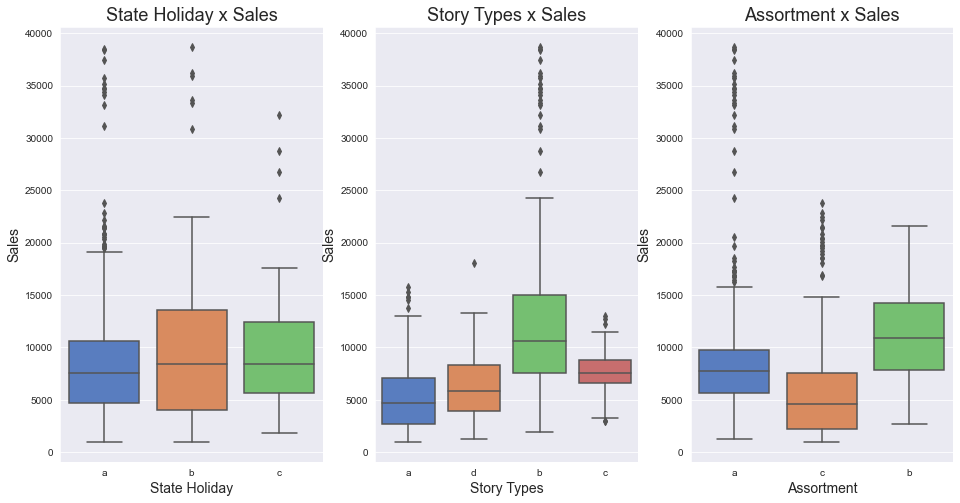

In [22]:
# Plotando boxplots das variáveis categóricas

# Restrigindo vendas 
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Utiliza o eixo vertical para um único eixo
fig, gr = plt.subplots()

# Tamanho da figura
gr.figure.set_size_inches(16,8)

# Gráficos
plt.subplot(1, 3, 1)
gr = sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1 )
set_plots_features(gr, 'State Holiday x Sales', 'State Holiday', 'Sales')

plt.subplot(1, 3, 2)
gr = sns.boxplot(x = 'store_type', y = 'sales', data = aux1 )
set_plots_features(gr, 'Story Types x Sales', 'Story Types', 'Sales')

plt.subplot(1, 3, 3)
gr = sns.boxplot(x = 'assortment', y = 'sales', data = aux1 )
set_plots_features(gr, 'Assortment x Sales', 'Assortment', 'Sales')

# Exibição dos gráficos
plt.show()

Pelos gráficos boxplots podemos observar que:

* O feriado tipo b possui vendas bem mais distribuidas do que as vendas dos feriados tipo a e tipo c. Porém as medianas de vendas nos feriados b e c são parecidas.


* A loja tipo b possui o maior número de vendas e o maior número de outliers entre as demais lojas. Depois loja tipo c tem uma mediana de vendas maior do que a mediana de vendas das lojas tipo a e d.


* O tipo de assortment b possui um número de vendas bem mais distribuido do que os tipos de assortment a e c. Porém, o número de outliers do assortment tipo a é maior do que as demais.


# 2.0. PASSO 02 - FEATURING ENGINEERING

Nesta etapa, irei fazer o Mapa Mental de Hipóteses, a Criação de Hipóteses e a Featuring Engineering para termos as variáveis disponíveis para estudo durante a **Análise Exploratória de Dados**. Antes, com o **módulo 1** já finalizado, vou fazer uma cópia do que já foi feito até agora.

In [23]:
# Salvando cópia do conjunto de dados
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

Vou começar a criar o **Mapa Mental de Hipóteses**. Esse passo é de extrema importância, pois ajudará a organizar as ideias de uma forma mais simples e eficiente do que estou querendo elaborar. Portanto, na imagem abaixo, colocarei algumas caraterísticas, requisitos dos quais considero relevantantes no momento de vendas.

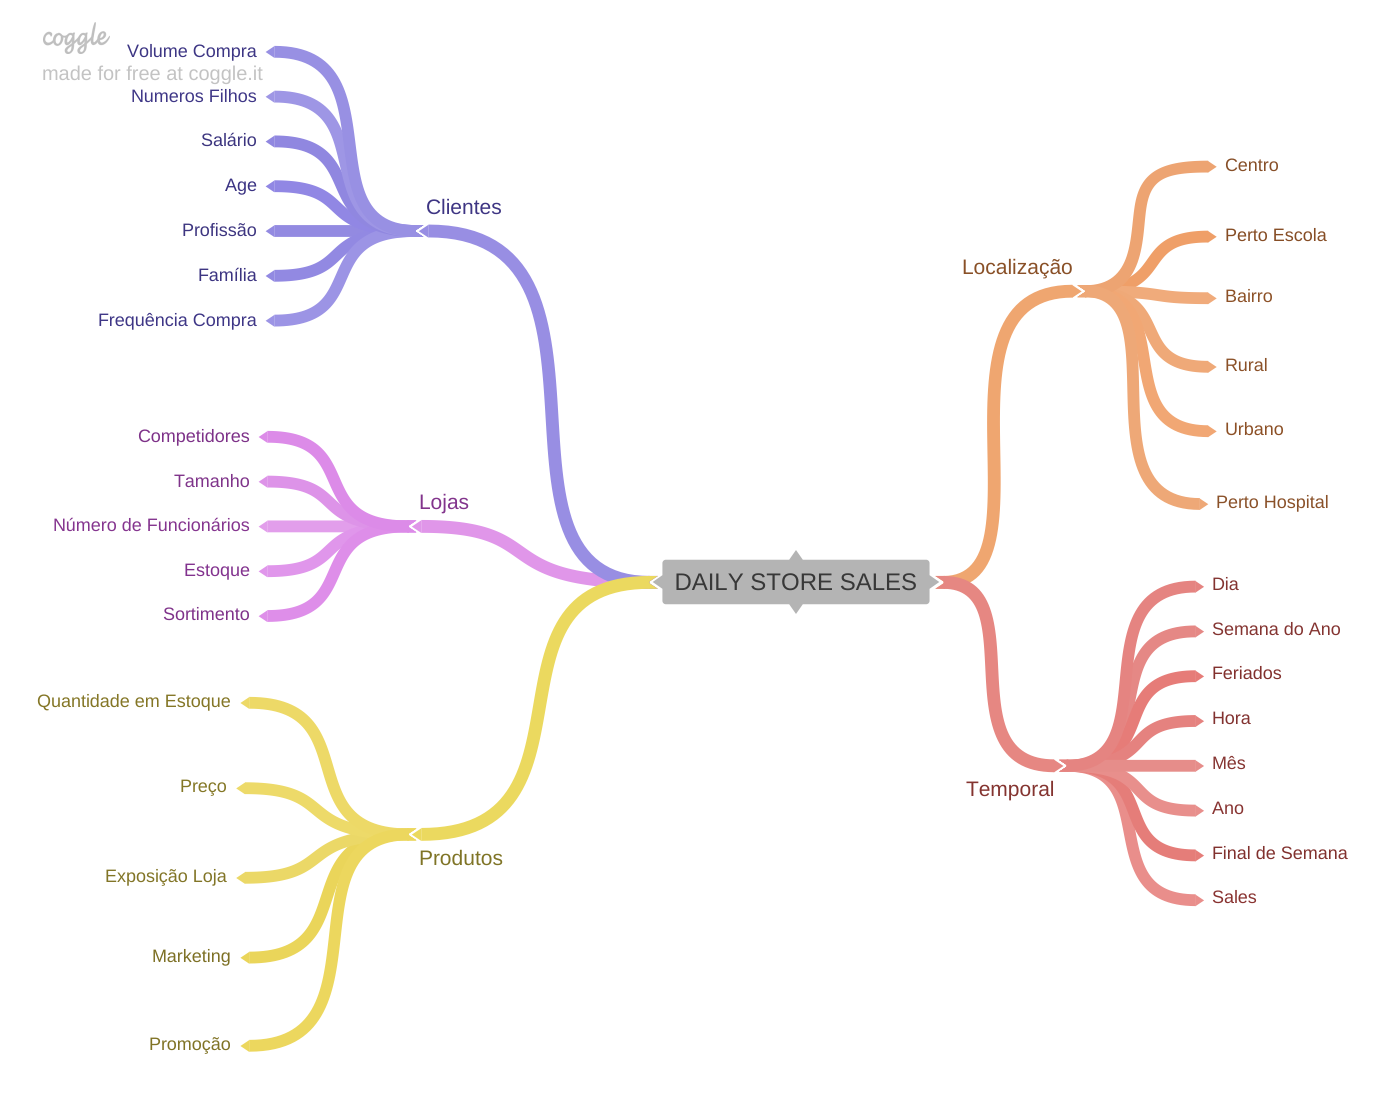

In [24]:
Image('/Users/diasn/projetos/DataScienceEmProducao/image/daily_store.png')

Observando a imagem acima, coloquei como filtro central a **venda diária das lojas**, pois estou buscando características que motivam as vendas nestes estabelecimentos. Logo, julgo necessário avaliar cinco requisitos que fazem as lojas terem vendas. No caso: clientes, lojas, produtos, localização e o tempo.


Elaborando o raciocínio desta forma, procurei colocar informações coerentes em cada requisito que façam as vendas acontecerem. Portanto, a partir desse **Mapa Mental**, vou criar as respectivas hipóteses baseando-se fundamentalmente em características como: **lojas, produtos e tempo**.

## 2.2. Criando Hipóteses

*Hipóteses sobre Lojas*

**1.** Lojas com mais empregados deve vender mais.

**2.** Lojas com maior capacidade de inventário deve vender mais.

**3.** Lojas maiores deveriam vender mais.

**4.** Lojas com maiores sortimentos deveriam vender mais.

**5.** Lojas com concorrentes mais próximos deveriam vender menos.

**6.** Lojas com concorrentes mais longe devem vender mais.


*Hipóteses sobre produtos*

**1.** Lojas que investem mais em marketing devem vender mais.

**2.** Lojas com maior exposição do produto devem vender mais.

**3.** Lojas com produtos de baixo preço devem vender mais.

**4.** Lojas com promoções mais agressivas (maiores descontos) devem vender mais.

**5.** Lojas com promoções activas durante mais tempo deverão vender mais.

**6.** Lojas com mais dias de promoção podem vender mais.

**7.** Lojas com mais promoções consecutivas devem vender mais.


*Hipóteses sobre o Tempo* 

**1.** Lojas que abrem no Natal devem vender mais.

**2.** Lojas devem vender mais ao longo dos anos.

**3.** Lojas devem vender mais no segundo semestre do ano.

**4.** Lojas devem vender mais após o dia 10 de cada mês.

**5.** Lojas devem vender menos nos fins-de-semana.

**6.** Lojas devem vender menos durante as férias escolares.



### 2.2.1 Lista Final de Hipóteses

**1.** Lojas com sortidos maiores deve vender mais.

**2.** Lojas com concorrentes mais próximos deve vender menos.

**3.** Lojas com concorrentes mais longe podem vender mais.

**4.** Lojas com promoções activas durante mais tempo devem vender mais.

**5.** Lojas com mais dias de promoção podem vender mais.

**6.** Lojas com mais promoções consecutivas devem vender mais.

**7.** Lojas que abrem no Natal devem vender mais.

**8.** Lojas que abrem no Natal devem vender mais ao longo dos anos.

**9.** Lojas devem vender mais no segundo semestre do ano.

**10.** Lojas devem vender mais após o dia 10 de cada mês.

**11.** Lojas devem vender menos nos fins-de-semana.

**12.** Lojas devem vender menos durante as férias escolares.

## 2.4. Featuring Engineering

Com a criação das hipóteses exercida, nesse passo irei fazer o processo de **Feature Engineering**, ou seja, criarei novas features com base no que já foi analisado na estatística descritiva e na criação das respectivas hipóteses.

Para fazer a validação das hipóteses **H9, H10, H11 e H12**, nas próximas seções, irei derivar a variável **'date'** para obter as vendas detalhadas por ano, mês, dia e semanas do ano.

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

Agora para as hipóteses, **H2** e **H3**, que correspondem ao periodo de competição, vou criar uma feature chamada **'competition_since'** que é juntando o mês (**'competition_open_since_month'**) e o ano (**'competition_open_since_year'**). E por último, farei a diferença entre as variáveis **'date'** e **'competition_since'** dividindo por 30, para criar a variável **'competition_time_month'**, que é o tempo em que a competição começou em meses.

In [26]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], day= 1), axis = 1)

# competition time month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

Em relação as hipóteses **H4**, **H5** e **H6**, que correspondem as promoções, vou fazer as seguintes manipulações para obter o tempo de promoção em meses. Para isso, criarei a feature **'promo_since'**. E depois fazendo o mesmo raciocínio que foi feito em **'competition_time_month'**, obterei a variável **'promo_time_week'**.

In [27]:
# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') 
                                              - datetime.timedelta(days = 7) )

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype(int)

Para as variáveis categóricas **'assortment'** e **'state_holiday'**, irei renomear cada nível com o seu significado conforme o **Dicionário de Dados**. 

In [28]:
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [29]:
# Verificando conjunto de dados com as novas features criadas
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRO DE VARIÁVEIS

Nesse passo, irei fazer o filtro de variáveis, isto é, analisarei o conjunto de dados para identificar, se é possível restringir, algum dado que não seja relevante para o problema de negócio que quero resolver. Diante, realizarei os seguintes passos:

* Filtro de Linhas


* Filtro de Colunas

No entanto, como procedimento já estabelecido, vou salvar uma cópia do Dataframe, antes de começar as atividades.

In [30]:
# Salvando cópia do conjunto de dados
df3 = df2.copy()

## 3.1. Filtro de Linhas

Começando pelo filtro de linhas, vou considerar apenas os dados das lojas que foram abertas e que tiveram vendas, pois não faz nenhum sentido deixar dados das lojas que foram fechadas, visto que, a ideia é fazer uma previsão de vendas.

In [31]:
# Considerando dados apenas que tiveram as lojas abertas e com vendas
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção de Colunas

Já para a seleção de colunas, irei analisar as colunas do conjunto de dados. 

In [32]:
# Visualizando dataset
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


Observando o conjunto de dados, não irei utilizar as colunas: **'customers'** - porque não temos o número de clientes no momento da previsão; **'open'** - porque estou considerando apenas as lojas abertas para modelo; **'promo_interval'** e **'month_map'** - porque só foram utilizadas para derivar outras variáveis.

In [33]:
# Removendo as colunas do dataset
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [34]:
# Verificando colunas
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [35]:
# Salvando cópia do conjunto de dados
df4 = df3.copy()

Em resumo, a importância da Análise Exploratória de Dados é compreender e medir forças de como as variáveis impactam no fenômeno que estamos modelando. Sendo assim, os objetivos da AED são:

* Ganhar experiência de negócio.


* Validar as hipóteses de negócios.


* Entender quais variáveis são importantes para o negócio.

Portanto, farei três tipos de análises: **análise univariada, análise bivariada e análise multivariada.**

## 4.1. Análise Univariada

Na análise univariada, estou buscando compreender o comportamento de cada variável em relação a si mesma para o negócio. Dessa forma, vou analisar a **variável alvo, as variáveis numéricas e as variáveis categóricas**.

### 4.1.1. Variável Alvo

A variável alvo, nesse caso é a variável resposta que são as **sales**.

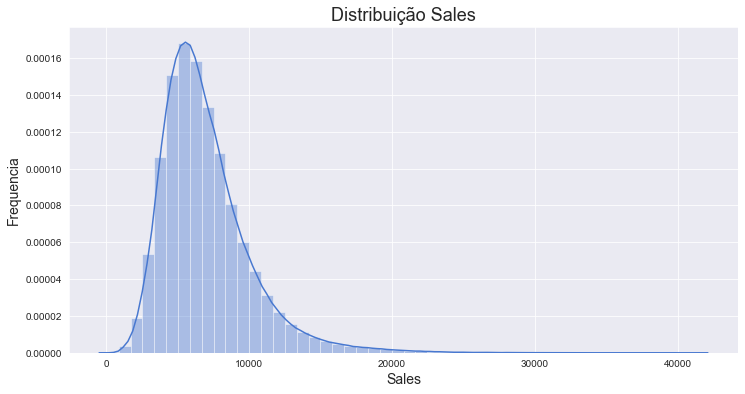

In [36]:
fig, gr = plt.subplots()

# Tamanho da figura
gr.figure.set_size_inches(12,6)

# Plotando distribuição
gr = sns.distplot(df4['sales'])
set_plots_features(gr, 'Distribuição Sales', 'Sales', 'Frequencia')

# Exibição do gráfico
plt.show()

Como podemos analisar, a distribuição das vendas é uma curva que se aproxima da distribuição normal, mas não é uma distribuição normal porque sua média e mediana são diferentes, apesar de serem próximas conforme observado na estatística descritiva. 

Existem técnicas que transformam essa distribuição em uma normal no qual isso será mencionado na próxima seção.

### 4.1.2. Variável Numérica

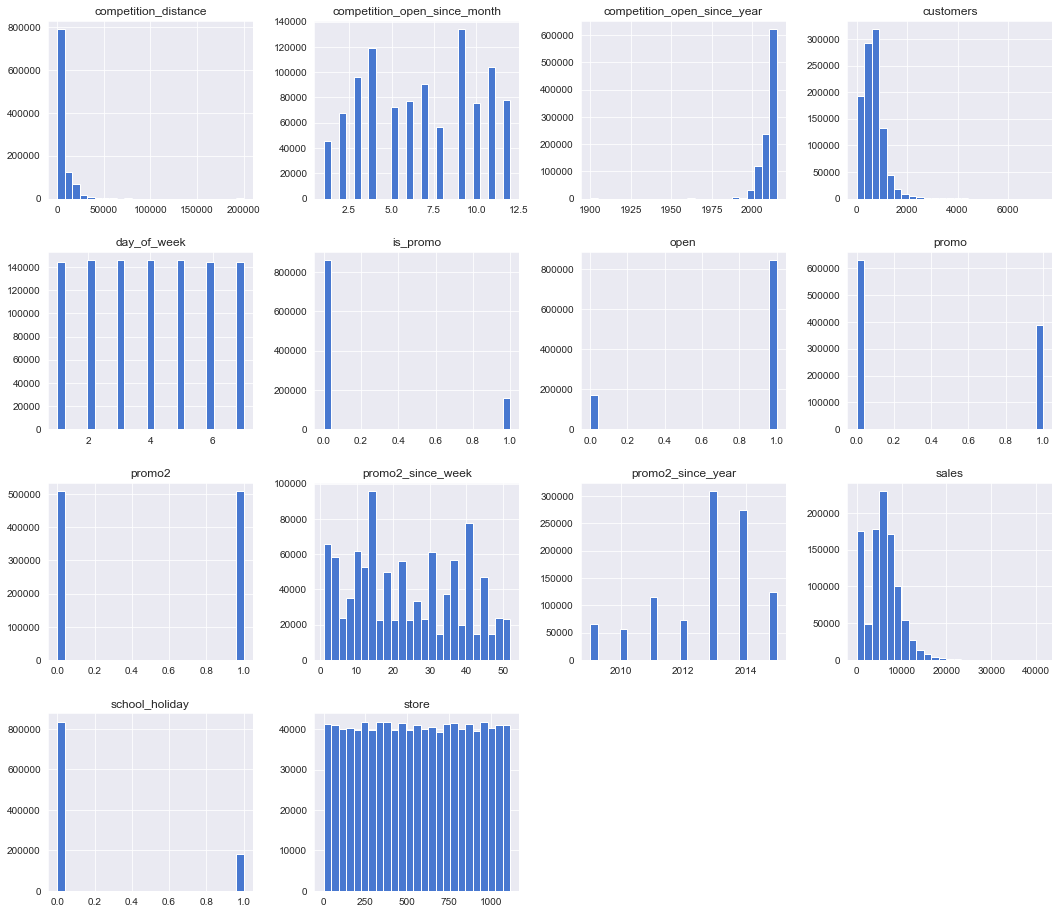

In [37]:
# Definindo o tamanho das figuras
fig = plt.figure(figsize = (18,16))

#sets axes
ax = fig.gca()

# Plotando histogramas
num_attributes.hist(ax = ax, bins=25);

Analisando os histogramas, temos que:

**Competition Distance:** os concorrentes se encontram num intervalo de 0 a 50000.

**Competition Open Since Month:** há um aumento da concorrência nos primeiros meses. Depois, nos meses de Maio a Agosto, há uma queda / estabilidade. E finalmente, nos meses de Setembro a Dezembro, há um aumento e uma diminuição. Isto gera uma sazonalidade.

**Competition Open Since Year**: as competições de lojas abertas tiveram um aumento crescente desde os anos 2000. Mas em 2015 o número de competições foi muito elevado.

**Customers**: o número de clientes por dia durante os primeiros 1000 dias é mais elevado. Mas depois, o número de clientes diminui consideravelmente.

**Day of Week**: o histograma tem uma distribuição uniforme, ou seja, as lojas abrem todos os dias da semana.

**Is Promo**: muitas lojas não estão em promoção (promo=0) do que em promoção (promo=1).

**Open**: há muitas lojas abertas (aberto=1) do que fechadas (aberto=0). Este resultado pode ser influenciado por lojas que abrem nos feriados.

**Promo**: há muito mais lojas que não estavam em promoção regular (promo=0) do que as que estavam (promo=1).

**Promo2**: existe um vínculo entre as lojas que participaram na promo2 e as lojas que não participaram na promo2.

**Promo2 Since Week**: o gráfico não apresenta uma conclusão imediata. Temos que analisar mais.

**Promo2 Since Year**: muitas lojas participaram na promoção nos anos 2013 e 2014.

**Sales**: houve muito mais vendas entre 0 e quase 10.000.

**School Holiday**: existem muitas mais lojas que não foram afetadas pelo encerramento de escolas públicas.

**Stores**: as variáveis das lojas descrevem uma identificação única para cada loja. Portanto, neste gráfico não há nada a extrair. 


### 4.1.3. Variáveis Categóricas

In [38]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [39]:
# Verifica valores únicos para 'state_holiday' que temos no conjunto de dados
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [40]:
# Verifica valores únicos para 'state_holiday'
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

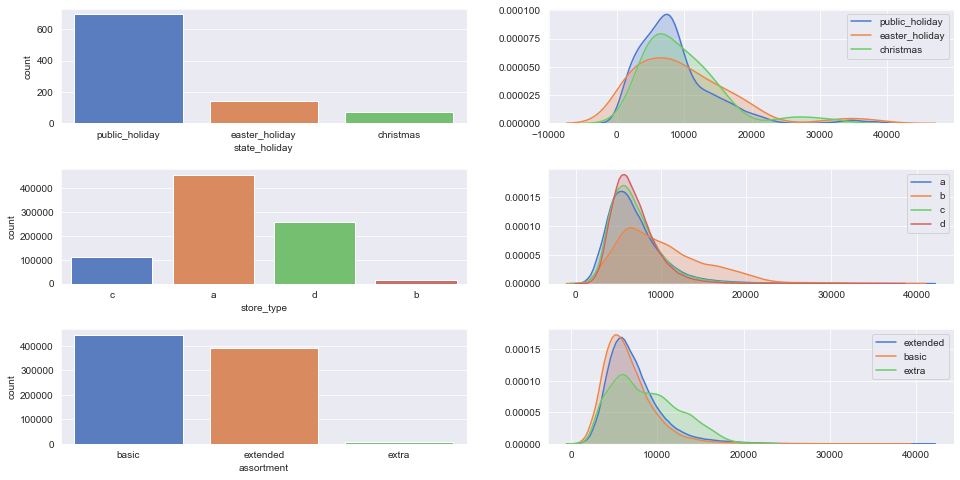

In [41]:
# Usa variável ax para um único eixo
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# State_holiday
plt.subplot(3,2,1)
df_no_regular_day = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(df_no_regular_day['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


# Store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

# Ajusta o espaço vertical entre os gráficos
plt.subplots_adjust(hspace = 0.4)

# Exibição do gráfico
plt.show()

Analisando os gráficos, observamos que:


* Embora haja muito mais lojas abertas nas férias da Páscoa, o volume de vendas é maior no Natal. Isto pode dever-se às vendas promocionais de Natal que as lojas têm até ao final do ano.


* Para as lojas de tipo a, c e d há uma alta concentração de vendas. Além disso, para as lojas de tipo b, o volume de vendas é menor e a sua gama de valores é muito mais distribuída. Como o conjunto de dados fornecido não descreve claramente a diferença entre os tipos de lojas, não é possível saber o que poderia estar a gerar estas diferenças.


* Para o tipo de sortido alargado, básico, existe uma alta concentração de vendas. Além disso, para o sortido extra, o volume de vendas é menor e a sua gama de valores é muito mais distribuída. Isto pode dever-se ao sortido de produtos que cada loja tem em stock e em venda, o que tem impacto no volume de vendas.

## 4.2. Análise Bivariada

Na análise bivariada, vou fazer a validação das hipóteses que foram definidas na Seção 2.

### **H1. Lojas com sortimentos maiores deveriam vender mais.**

*FALSO Lojas com maior sortimento vendem menos*.

In [42]:
# Quantidade vendas por sortimentos
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

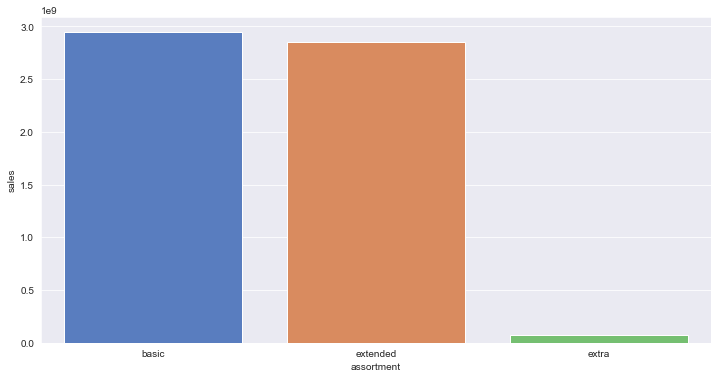

In [43]:
fig, gr = plt.subplots()

# Tamanho da figura
gr.figure.set_size_inches(12,6)

# Plotando gráfico de barras
gr = sns.barplot(x = 'assortment', y ='sales', data = aux1)
set_plots_features(ax, 'Total Sales for Each Assortment Type', 'Assortment Type', 'Total Sales' )

# Exibindo gráfico
plt.show()

Assumindo que os maiores sortimentos são do tipo extra e analisando o gráfico, verifico que as vendas de sortimentos extra são pequenas em comparação com os tipos básicos e alargados. Portanto, concluo que **as lojas com sortimentos maiores vendem menos**.

No entanto, podemos nos perguntar se houve alguma mudança no comportamento de vendas ao longo do tempo. Para tal, irei verificar as **vendas** para cada sortimento durante as **semanas dos anos**.

In [44]:
# Verificando cada venda de sortimento
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
5,2013-01,extra,350279
6,2013-02,basic,17970974
7,2013-02,extended,16029584
8,2013-02,extra,377207
9,2013-03,basic,24392076


In [45]:
# Criação de uma tabela pivot
aux3 = aux2.pivot(index='year_week', columns = 'assortment', values='sales')
aux3

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
2013-05,25752621,22839180,410482
2013-06,18616937,17236467,416260
2013-07,24976734,22294188,431015
2013-08,19863755,18333986,425147


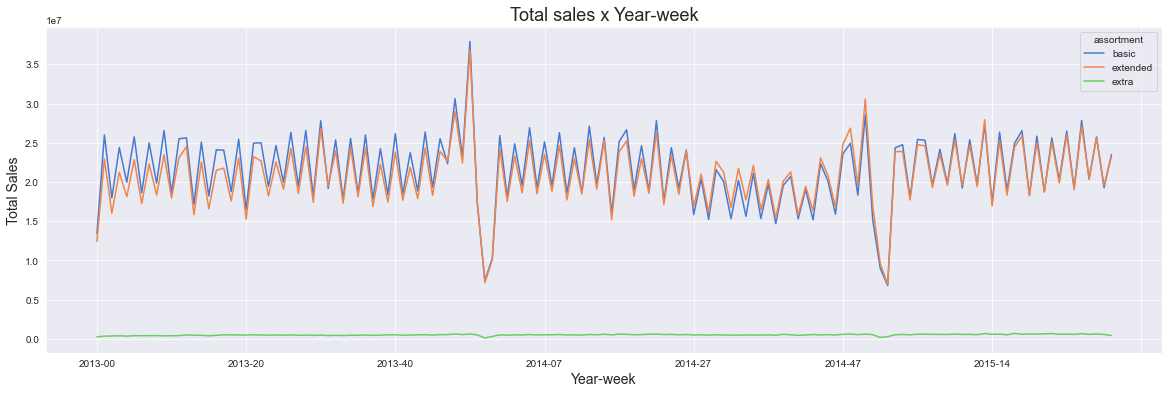

In [46]:
#plot a lineplot for 'aux3'
ax = aux3.plot()

#set the figure size in inches
ax.figure.set_size_inches(20,6)

#set the title and axis labels
set_plots_features(ax, 'Total sales x Year-week','Year-week','Total Sales' )

#displays the plot
plt.show()

Olhando para o gráfico acima, concluo que as vendas dos tipos de sortimentos básicos e alargados são praticamente as mesmas ao longo do tempo. Mas, preciso verificar a linha que descreve o comportamento de vendas do sortido de tipo extra. 

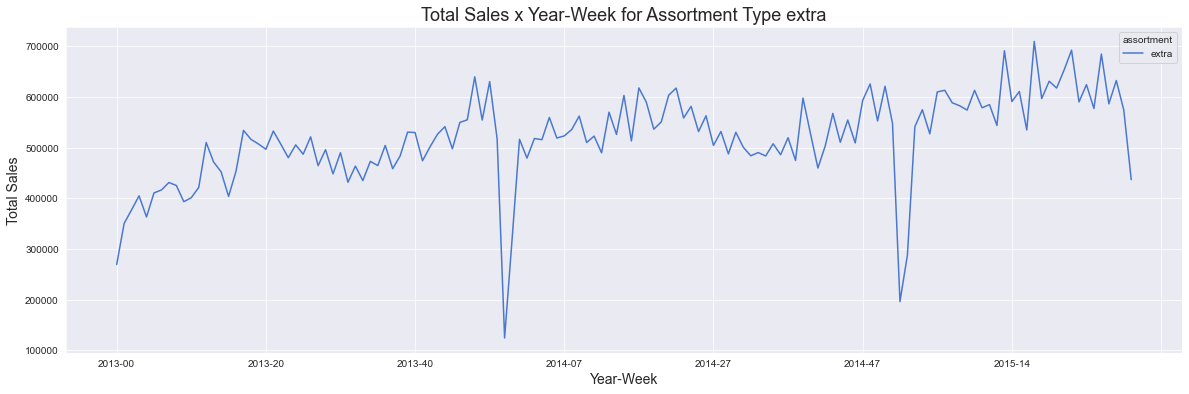

In [47]:
aux4 = aux2[aux2['assortment'] == 'extra']

ax = aux4.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

#sets the figure size in inches
ax.figure.set_size_inches(20,6)

#sets the title and axis labels
set_plots_features(ax, 'Total Sales x Year-Week for Assortment Type extra', 'Year-Week', 'Total Sales')

#displays the plot
plt.show()


Olhando para os gráficos de linha, posso ver que as lojas com o maior (extra) sortido têm o menor volume de vendas. Portanto, a hipótese é **FALSA**

### **H2. Lojas com competidores mais próximos devem vender menos**

*FALSA Lojas com competidores mais próximos vendem mais*

In [48]:
# Verificando as vendas totais para cada "competition distance"
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux1

,competition_distance,sales
0,20.0,4579807
1,30.0,17552666
2,40.0,29261626
3,50.0,60835848
4,60.0,22088359
5,70.0,30177156
6,80.0,14892099
7,90.0,49417211
8,100.0,24829560
9,110.0,31718444


In [49]:
#create bins that range 0 to 20000 with steps of 1000
bins = list(np.arange(0, 20000, 1000))

#places the data in the bins
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

aux1.sample(10)

,competition_distance,sales,competition_distance_binned
102,1120.0,4787781,"(1000, 2000]"
294,3850.0,4079175,"(3000, 4000]"
158,1800.0,7021213,"(1000, 2000]"
145,1630.0,4883888,"(1000, 2000]"
238,2920.0,5656109,"(2000, 3000]"
392,6360.0,11444198,"(6000, 7000]"
138,1530.0,14082141,"(1000, 2000]"
381,5900.0,5307253,"(5000, 6000]"
461,8980.0,13446253,"(8000, 9000]"
156,1780.0,4317171,"(1000, 2000]"


In [50]:
#get the total sales for each bin
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
aux2

,competition_distance_binned,sales
0,"(0, 1000]",1832415839
1,"(1000, 2000]",918682669
2,"(2000, 3000]",610405362
3,"(3000, 4000]",378745560
4,"(4000, 5000]",325665741
5,"(5000, 6000]",218735915
6,"(6000, 7000]",168769215
7,"(7000, 8000]",133211838
8,"(8000, 9000]",180027950
9,"(9000, 10000]",121250715


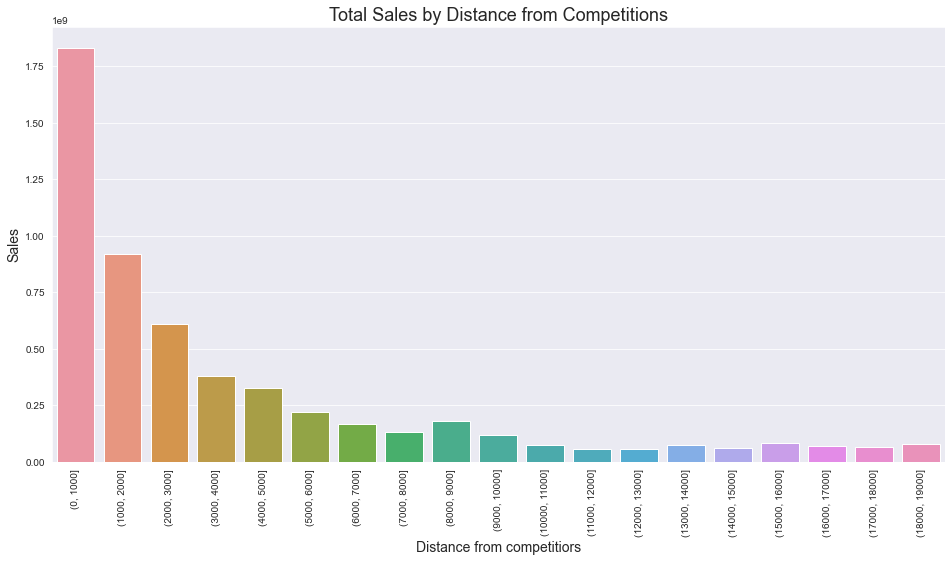

In [51]:
#uses the variable ax for single a Axes
fig, ax = plt.subplots()

#sets the figure size in inches 
ax.figure.set_size_inches(16,8)

#plot a barplot
ax = sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2)

#rotates labels
plt.xticks(rotation = 90)

#sets the title and axis labels 
set_plots_features(ax ,'Total Sales by Distance from Competitions','Distance from competitiors', 'Sales')

#displays the plot
plt.show()

Observando os resultados, as lojas com competidores mais próximos vendem mais. Por conseguinte, a hipótese é **FALSA**.

Podemos também traçar um gráfico de dispersão para verificar este resultado. 

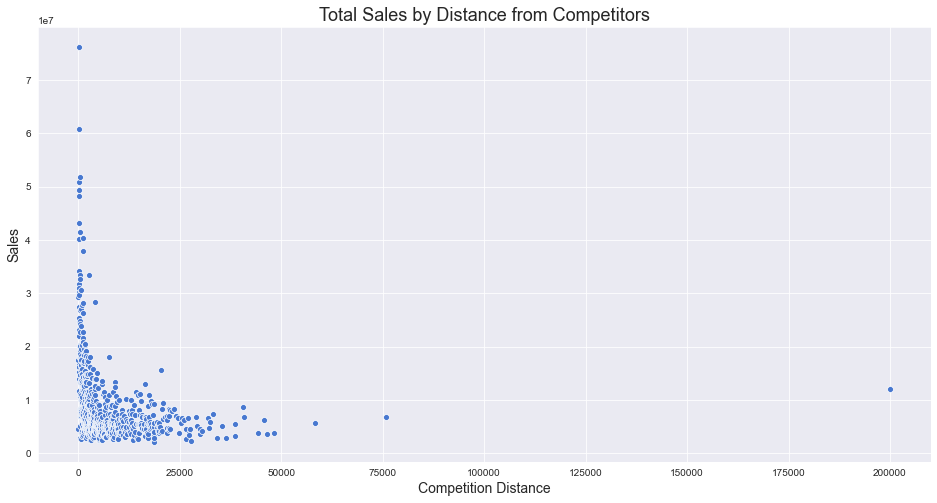

In [52]:
#check total sales for each 'competition_distance'
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#uses the variable ax for single a Axes
figure, ax = plt.subplots()

#sets the figure size in inches 
ax.figure.set_size_inches(16,8)

#plots a scatter plot for sales in relation to competition_distance
ax = sns.scatterplot(x='competition_distance', y = 'sales', data = aux1)

#title and axis labels
set_plots_features(ax, 'Total Sales by Distance from Competitors', 'Competition Distance', 'Sales')

#displays the plot
plt.show()

No gráfico de dispersão, a concentração dos pontos de venda ocorre em lojas com competidores mais próximos. Isto também confirma a hipótese **FALSA**.

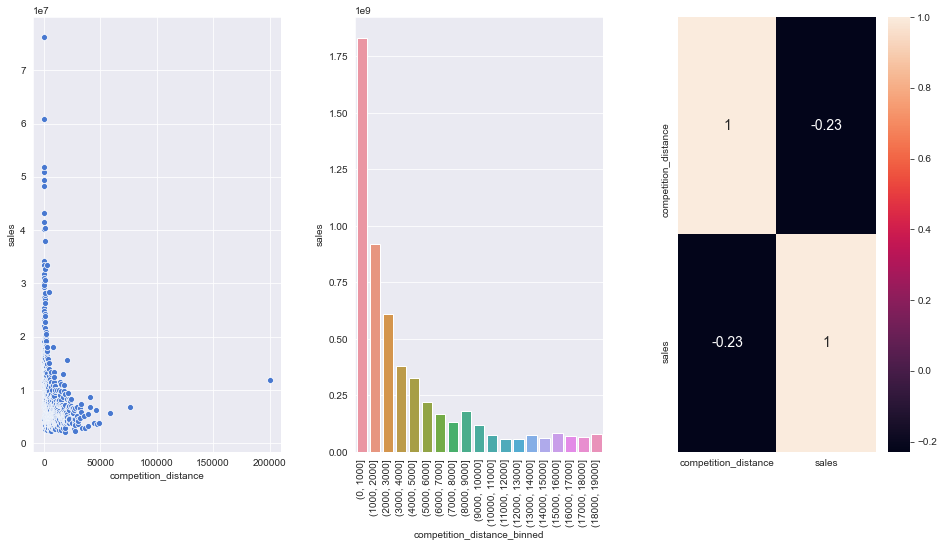

In [53]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
plt.subplot(1, 3, 1)
ax = sns.scatterplot(x='competition_distance', y='sales', data=aux1)


# plots a bar plot
plt.subplot(1, 3, 2)
ax = sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

# rotates xlabels
plt.xticks(rotation = 90)


# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# adjusts the width spaces between plots
plt.subplots_adjust(wspace = 0.3)

# displays the plots
plt.show()

Tendo em conta a correlação de Pearson, podemos ver que o resultado de **-0,23** é uma ** fraca correlação negativa***. Isto explica que quanto mais longe estiverem os competidores, mais baixas serão as vendas da loja.

### **H3. As lojas com competições mais longas podem vender mais**

*FALSA Lojas com competições mais longas vendem menos.*

In [54]:
# Obtendo todas as vendas por mês desde que a loja da concorrência abriu
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

aux2

,competition_time_month,sales
0,-32,198200
1,-31,993663
2,-30,2232685
3,-29,3175827
4,-28,4157527
5,-27,5178462
6,-26,5641349
7,-25,5978239
8,-24,6457582
9,-23,7525436


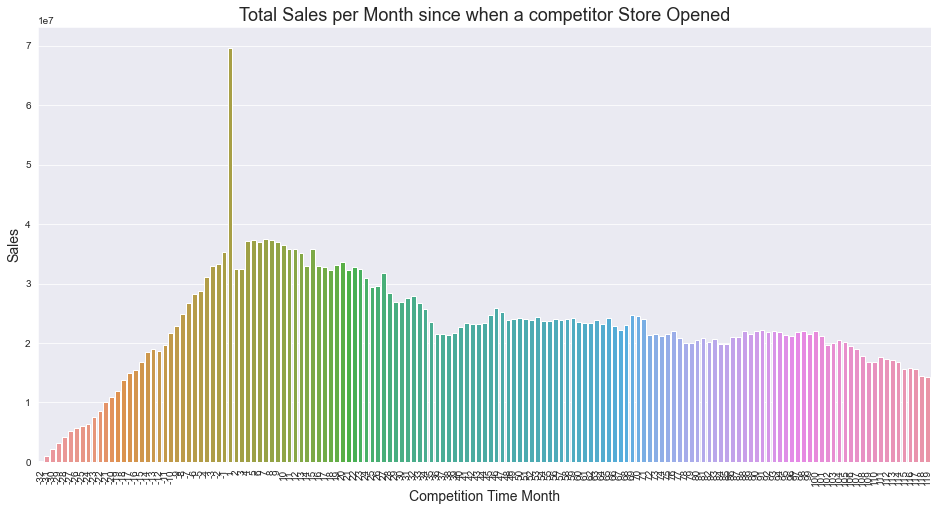

In [55]:
# uses variable ax for single a Axes
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16,8)

# Plotando gráfico de barras
ax = sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)

# Rotacionando legendas
plt.xticks(rotation = 90)

# Configurando Título e eixos
set_plots_features(ax, 'Total Sales per Month since when a competitor Store Opened', 'Competition Time Month', 'Sales')

#display plot
plt.show()

Analisando o gráfico de barras, posso ver que quanto mais valores negativos se aproximam de 0, as vendas são mais elevadas. O que isso significa ?
Significa que as lojas com concursos recentes vendem mais. Por outro lado, as lojas com competições mais longas vendem menos.
Portanto, a hipótese é **FALSA**.

Vamos traçar a correlação do Pearson de acordo com o código.

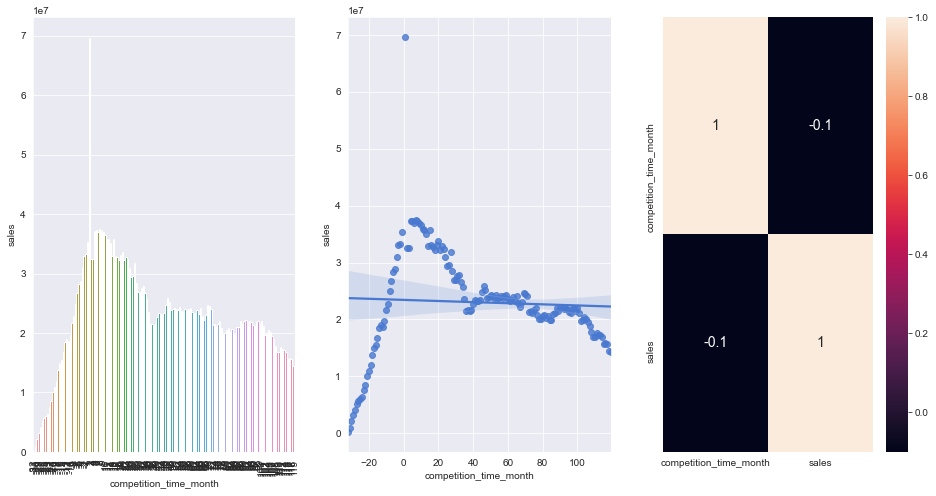

In [56]:
# Usando a variável ax para um único eixo
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# Plotando gráfico de barras
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)

# rotates the xticks
plt.xticks(rotation=90)

# Plotando reta de regressão
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

# Plotando mapa de calor
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# Exibindo gráficos
plt.show()

A correlação de Pearson é fraca porque o seu resultado é **-0,10**. Mas, este resultado é importante porque influencia a resposta variável que são as vendas. Por outro lado, é necessário utilizar outro tipo de correlação para medir a dispersão dos pontos e o erro. 

### **H4. Lojas com promoções ativas por mais tempo devem vender mais**

*FALSA  Lojas com promoções ativas por mais tempo vendem menos*

In [57]:
# Obtendo vendas totais com base em quanto tempo uma promoção esteve ativa
aux = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
aux

,promo_time_week,sales
0,-126,80706
1,-125,147212
2,-124,107127
3,-123,140121
4,-122,116593
5,-121,185994
6,-120,207368
7,-119,199336
8,-118,202049
9,-117,281798


<h3>Leitura da tabela acima</h3>

    
1) promo_time_week > 0: vendas efetuadas dentro do tempo de promoção **extendido** .

2) promo_time_week < 0: vendas efetuadas dentro do tempo de promoção **regular**.


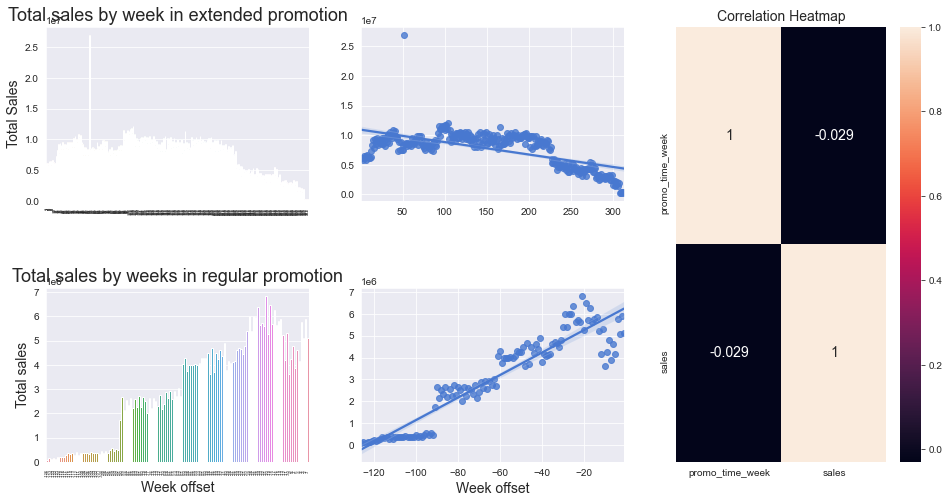

In [58]:
from matplotlib.gridspec import GridSpec

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

grid = GridSpec(2, 3)

# Ajustando o espaço entre os gráficos
plt.subplots_adjust(hspace = 0.5)

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# Obtendo os dados estendidos da promoção
aux1 = aux[aux['promo_time_week'] > 0]

# Plotando um gráfico de barras
plt.subplot(grid[0,0])
ax1 = sns.barplot(x='promo_time_week', y = 'sales', data = aux1);

# Define os rótulos de título e eixos
set_plots_features(ax1, "Total sales by week in extended promotion", " ", "Total Sales")

# Rotacionando as legendas
plt.xticks(rotation = 90, fontsize = 4);

# Plotando a reta de regressão
plt.subplot(grid[0,1])
ax2 = sns.regplot(x ='promo_time_week', y ='sales', data=aux1)

# Define os rótulos de título e eixos
set_plots_features(ax2," ", " ", " ")

# Obtendo os dados regulares da promoção
aux2 = aux[aux['promo_time_week'] < 0]


# Plotando gráfico de barras
plt.subplot(grid[1,0])
ax3 = sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);

# Define os rótulos de título e eixos
set_plots_features(ax3, "Total sales by weeks in regular promotion", "Week offset", "Total sales")

# Rotacionando as legendas
plt.xticks(rotation=90, fontsize=4)

# Plotando a reta de regressão
plt.subplot(grid[1,1])
ax4 = sns.regplot(x ='promo_time_week', y ='sales', data=aux2)

# Define os rótulos de título e eixos
set_plots_features(ax4, " ", "Week offset", " ")

# Plotando mapa de calor da correlação
plt.subplot(grid[:,2])
ax5 = sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# Define titulo
ax5.set_title("Correlation Heatmap", fontsize=14)

# Exibindo gráficos
plt.show()

Como podemos ver no total de vendas x semanas em promoção prolongada, há um período em que a promoção prolongada resulta em mais vendas. Após um período de tempo, as vendas totais começam a diminuir.

A partir do total de vendas x semanas em promoção regular, podemos ver que, à medida que a compensação se aproxima de zero, as vendas começam a aumentar.

Portanto, as lojas com um período de promoção mais longo não têm vendas mais elevadas. A hipótese é **FALSA**.

Em relação ao mapa de correlação de calor, obtivemos um coeficiente de **-0,029** que está muito próximo de zero. Por conseguinte, temos uma correlação super fraca. Este resultado faz sentido porque tem vendas que são frequentemente constantes ao longo do tempo.

Portanto, talvez não incluamos promo_time_week no modelo. Claro que esta variável pode funcionar se a combinarmos com outra variável, mas por agora vamos deixá-la.

### <s>**H5. Stores with more promotion days can sell more**</s>

Como esta hipótese é semelhante a **H4**. Partiremos para a validar no próximo ciclo CRISP.

###  **H6. Lojas com mais promoções consecutivas devem vender mais**

*FALSA Lojas com mais promoções consecutivas vendem menos*.

In [59]:
# Obtendo vendas totais feitas com base na promoção e promoções consecutivas
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Olhando para os resultados, houve mais vendas quando havia apenas uma promoção (promoção = 1 e promoção2 = 0) do que quando havia promoções consecutivas (promoção = 1 e promoção2 = 1).

In [60]:
# Obtendo todas as linhas em que houve promoções consecutivas
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1

,year_week,sales
0,2013-01,20995409
1,2013-03,19481514
2,2013-05,20580811
3,2013-07,20273185
4,2013-09,21451952
5,2013-11,20642219
6,2013-12,19843420
7,2013-14,20350155
8,2013-16,19069243
9,2013-17,19068319


In [61]:
# Obtendo todas as linhas em que não houve promoções consecutivas
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2

,year_week,sales
0,2013-01,22118270
1,2013-03,20567037
2,2013-05,22087889
3,2013-07,21631750
4,2013-09,22727171
5,2013-11,21836219
6,2013-12,21251247
7,2013-14,21519471
8,2013-16,20471898
9,2013-17,20589637


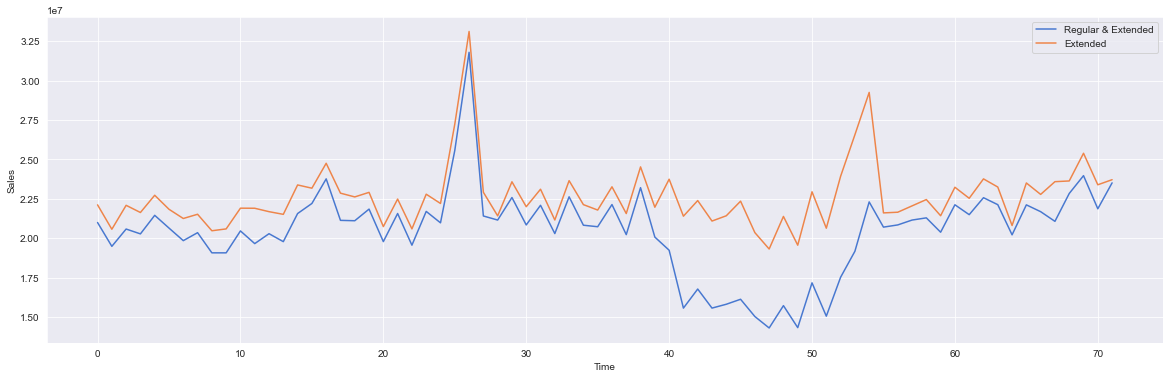

In [62]:
# Plotando linha
ax = aux1.plot()

# Plotagens na mesma grade
aux2.plot(ax = ax)

# Tamnho da figura
ax.figure.set_size_inches(20,6)

# Define legendas
ax.legend(labels=['Regular & Extended', 'Extended']);
plt.xlabel('Time')
plt.ylabel('Sales')

# Exibição do gráfico
plt.show()

Olhando para os resultados, parece que as lojas com mais promoções consecutivas vendem menos. Portanto, a hipótese é **FALSA**. Quanto à relevância da variável promo2 para o modelo ML, podemos dizer que a sua relevância é baixa.

### **H7. Lojas que abrem no Natal devem vender mais**

*FALSA Lojas que abrem no Natal vendem menos*

In [63]:
# Obtendo apenas os feriados, excluindo os dias normais
aux1 = df4[df4['state_holiday'] != 'regular_day']

# Obtendo o total de vendas por feriado estadual
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305


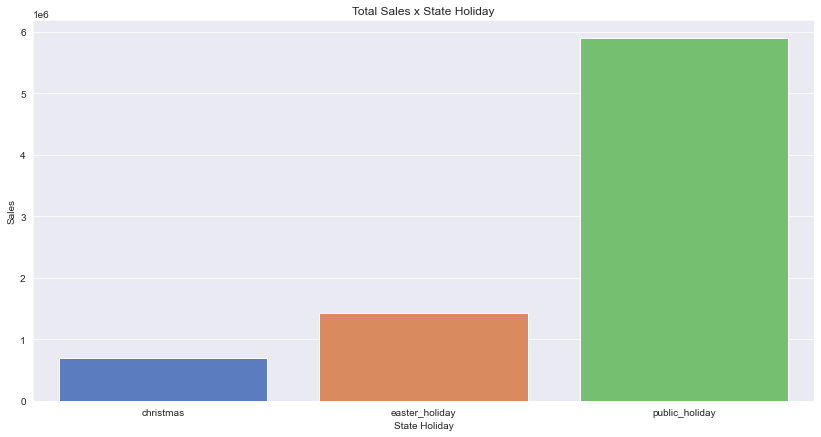

In [64]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(14,7)

# Plotando gráfico de barras
sns.barplot(x ='state_holiday', y ='sales', data = aux2)

# Definindo legendas
plt.title('Total Sales x State Holiday')
plt.xlabel('State Holiday')
plt.ylabel('Sales')

# Exibindo gráfico
plt.show()

In [65]:
# Obtendo vendas totais por ano e feriado estadual
aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
aux3

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


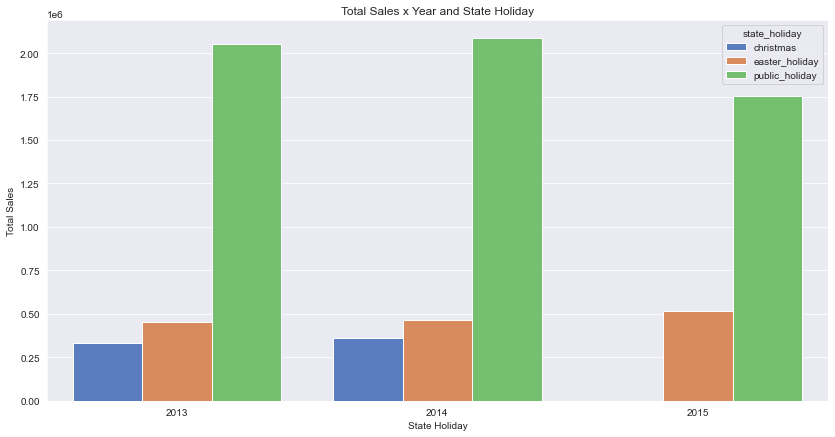

In [66]:
fig, ax = plt.subplots()

# Tamanho da Figura
ax.figure.set_size_inches(14,7)

# Plotando gráfico de barras
sns.barplot(x ='year', y ='sales', hue = 'state_holiday', data = aux3)

# Definindo titulo e eixos
plt.title('Total Sales x Year and State Holiday')
plt.xlabel('State Holiday')
plt.ylabel('Total Sales')

# Exibição do gráfico
plt.show()

Analisando os resultados acima, concluo que as lojas que abrem no Natal vendem menos. Portanto, a hipótese é **FALSA**.

Uma observação que faço aqui é que, em 2015, ainda não tem dados sobre as vendas de Natal, porque os dados terminam a 31 de Julho de 2015. Talvez posso considerar estas variáveis relevantes para o modelo de Machine Learning porque tem mudanças nas vendas dependendo do tipo de estado das férias e em que ano.

### **H8. Lojas devem vender mais oa longo dos anos**

*FALSA Lojas vendem menos ao longo dos anos.*

In [67]:
# Obtendo o total de vendas por ano
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
aux

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


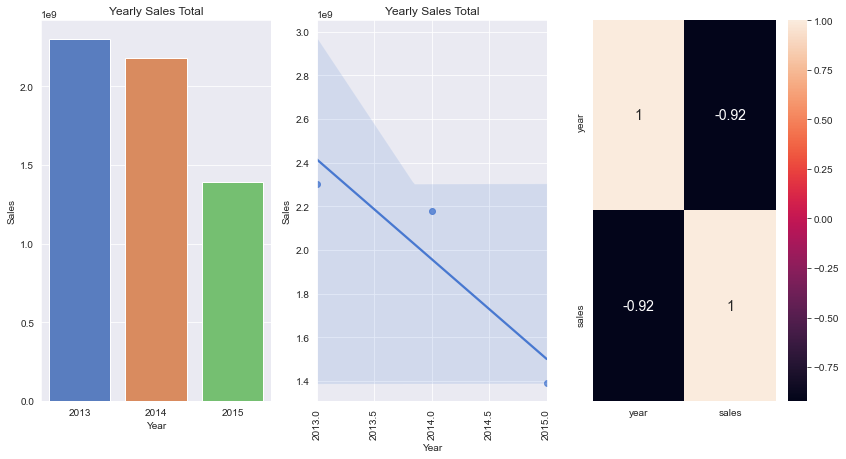

In [68]:
fig, ax = plt.subplots()

# Tamnho da figura
ax.figure.set_size_inches(14,7)

# Plotando gráfico de barras
plt.subplot(1, 3, 1 )
ax = sns.barplot( x = 'year', y = 'sales', data = aux)

# Título e eixoss
plt.title('Yearly Sales Total')
plt.xlabel('Year')
plt.ylabel('Sales')

# Plotando gráfico de barras
plt.subplot(1, 3, 2)
ax = sns.regplot(x='year', y='sales', data=aux)

# Define títulos e eixos
plt.title('Yearly Sales Total')
plt.xlabel('Year')
plt.ylabel('Sales')

# Rotacionando labels
plt.xticks(rotation=90)


# Plotando mapa de calor
plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# Exibindo gráfico
plt.show()

Observando os resultados acima, infiro que as lojas vendem menos ao longo dos anos. Além disso, o coeficiente de -0,92 é negativo e forte, o que significa que conforme os anos passam as vendas diminuem. Portanto, a hipótese é **FALSA**.

### H9. Lojas devem vender mais no segundo semestre do ano

*FALSA Lojas vendem menos no segundo semestre do ano.*

In [69]:
# Obtendo o total de vandas por mês
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()
aux

,month,sales
0,1,566728724
1,2,528734410
2,3,599831906
3,4,575895295
4,5,569248217
5,6,578112775
6,7,595059205
7,8,361791202
8,9,342570131
9,10,351878728


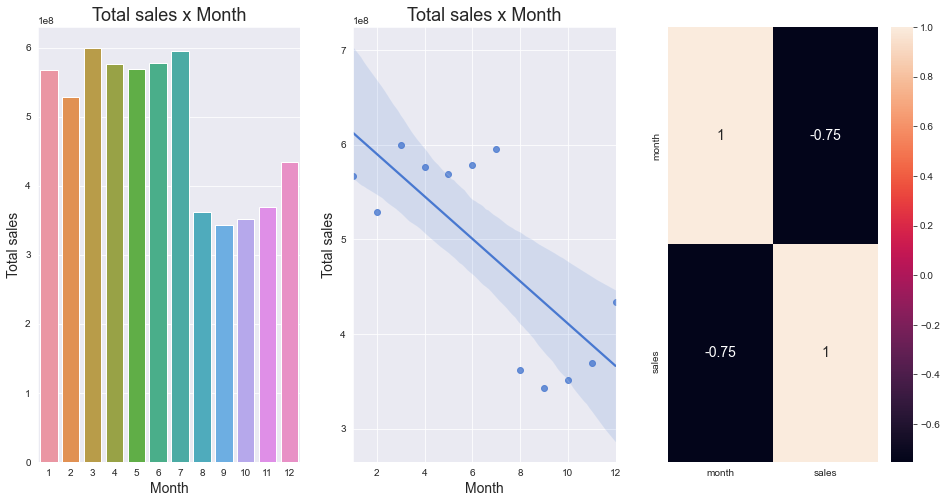

In [70]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# Plotando gráfico de barras
plt.subplot(1, 3, 1)
ax = sns.barplot(x='month', y='sales', data=aux)

# Defininindo Título e eixos
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# Plotando gráfico de barras
plt.subplot(1, 3, 2)
ax = sns.regplot(x='month', y='sales', data=aux)

# Defininindo Título e eixos
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# Plotando gráfico de barras
plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# Exibindo gráficos
plt.show()

Como observado nos resultado acima, concluo que as lojas vendem menos no segundo semestre do ano. Além disso, olhando para o coeficiente de correlação de -0,75, verifico que existe uma correlação forte negativa entre o meses e as vendas, o que significa que as vendas caem ao longo do tempo.

Portanto, a hipótese é **FALSA**.

### H10. Lojas devem vender mais após o dia 10 de cada mês

*VERDADEIRO Lojas vendem mais após o dia 10 de cada mês.*

In [71]:
# Obtendo o total de vendas antes e depois do 10º dia do mês
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux

,day,sales
0,1,155983560
1,2,233513169
2,3,194582812
3,4,228301010
4,5,212869176
5,6,197094539
6,7,201380487
7,8,189718770
8,9,175922427
9,10,181039363


In [72]:
# Classificando qual dia é antes e depois do 10º dia do mês
df4['before_after'] = df4['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

# Obtendo o total de vendas antes e depois do 10º dia do mês
aux1 = df4[['before_after', 'sales']].groupby('before_after').sum().reset_index()

aux1

,before_after,sales
0,after_10_days,3902775310
1,before_10_days,1970405313


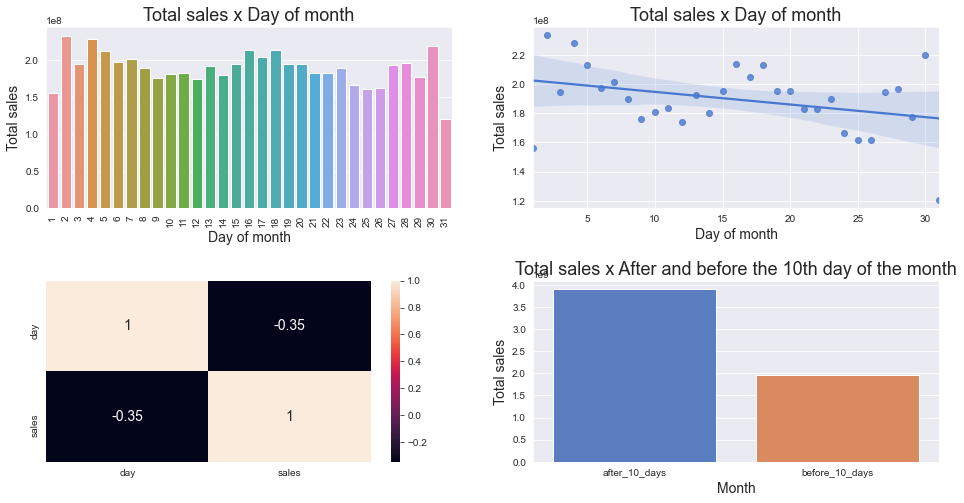

In [73]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# Plotando gráfico de barras
plt.subplot(2, 2, 1)
ax = sns.barplot(x='day', y='sales', data=aux)

# Define titulos e eixos
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")

# Rotacionando legendas
plt.xticks(rotation=90)

# Plotando reta de regressão
plt.subplot(2, 2, 2)
ax = sns.regplot(x='day', y='sales', data=aux)

# Define títulos e eixos
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")


# Plotando gráfico de barras
plt.subplot(2, 2, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})


# Plotando gráfico de barras
plt.subplot(2, 2, 4)
ax = sns.barplot(x='before_after', y='sales', data=aux1)

# Define título e eixos
set_plots_features(ax, "Total sales x After and before the 10th day of the month", "Month", "Total sales")

# Ajusta o espaço vertical entre os gráficos
plt.subplots_adjust(hspace = 0.4)

# Exibindo gráficos
plt.show()

Observando os resultados acima, concluo que as lojas vendem mais após o décimo dia de cada mês. Portanto, a hipótese é **VERDADEIRA**.

Além disso, o coeficiente de correlação não é tão forte, 0,35, entre os dias e as vendas. No entanto, como tem valores diferentes para o total de vendas antes e depois do décimo dia do mês, esta variável pode ser relevante para o modelo de Machine Learning.

### H11. Lojas devem vender menos nos finais de semana.

*VERDADEIRO Lojas vendem menos nos finais de semana.*

In [74]:
# Obtendo o total de vendas por day_of_week
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

aux

,day_of_week,sales
0,1,1130203012
1,2,1020411930
2,3,954962863
3,4,911177709
4,5,980555941
5,6,846317735
6,7,29551433


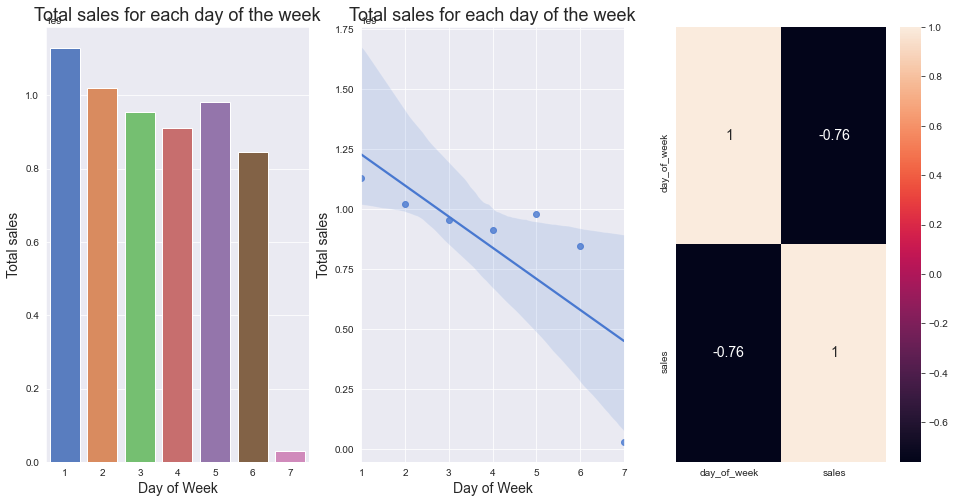

In [75]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# Plotando gráfico de barras
plt.subplot(1, 3, 1)
ax = sns.barplot(x='day_of_week', y='sales', data=aux)

# Define titulo e labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")


# Plotando gráfico de barras
plt.subplot(1, 3, 2)
ax = sns.regplot(x='day_of_week', y='sales', data=aux)

# Define título e labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")

# Plotando mapa de calor
plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# Exibindo gráficos
plt.show()

Como observado nos resultados acima, concluo que as lojas vendem menos nos fins de semana. Além disso, o coeficiente de correlação de -0,76 é forte negativo, o que significa que conforme passam os dias da semana, as vendas diminuem. 

Portanto, a hipótese é **VERDADEIRA**.

### H12. Lojas devem vender menos durante as férias escolares.

*VERDADEIRO Lojas vendem menos durante as férias escolares*

In [76]:
# Obtendo o total de vendas nas férias escolares
aux = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

aux

,month,school_holiday,sales
0,1,0,490739687
1,1,1,75989037
2,2,0,476170426
3,2,1,52563984
4,3,0,529719808
5,3,1,70112098
6,4,0,432131835
7,4,1,143763460
8,5,0,523512599
9,5,1,45735618


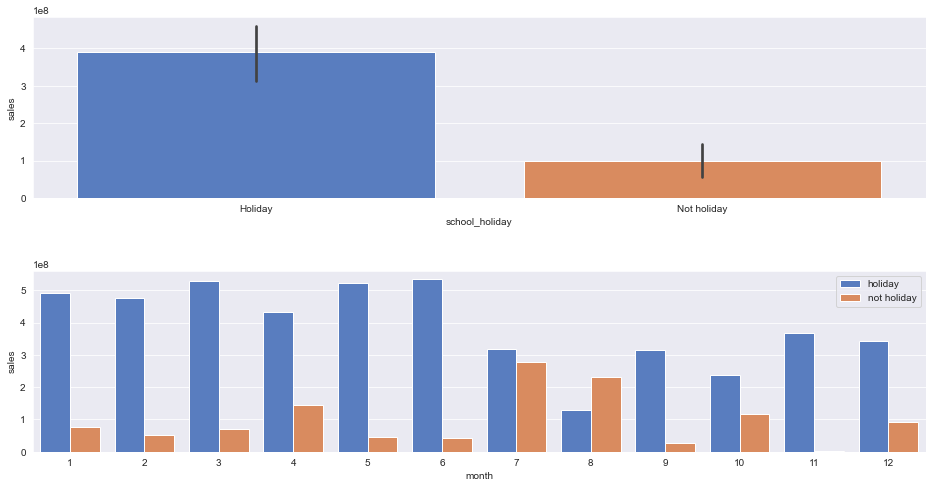

In [77]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# Plotando gráfico de barras
plt.subplot(2, 1, 1)
ax = sns.barplot(x='school_holiday', y='sales', data=aux)

# Define labels
ax.set_xticklabels(['Holiday','Not holiday'])

# Plotando gráfico de barras
plt.subplot(2, 1, 2)
ax = sns.barplot(x='month', y='sales', hue='school_holiday', data=aux)

# Define legendas
labels = ['holiday','not holiday']
h, _ = ax.get_legend_handles_labels()
ax.legend(h, labels)

# Ajusta o espaço vertical entre os gráficos
plt.subplots_adjust(hspace = 0.4)

# Exibindo gráficos
plt.show()

Como observado nos resultado acima, lojas vendem menos durante as férias escolares, exceto em Julho (7) e Agosto (8). Portanto, a hipótese é **VERDADEIRA**.

### 4.2.1. Sumario de Hipóteses

In [78]:
tab = [
    ['Hipóteses','Conclusão','Importância para o Modelo de Machine Learning'],
    ['H1','Falso','Baixa'],
    ['H2','Falso','Média'],
    ['H3','Falso','Média'],
    ['H4','Falso','Baixa'],
    ['H5','--','--'],
    ['H6','Falso','Baixa'],
    ['H7','Falso','Média'],
    ['H8','Falso','Alta'],
    ['H9','Falso','Alta'],
    ['H10','Verdadeiro','Alta'],
    ['H11','Verdadeiro','Alta'],
    ['H12','Verdadeiro','Baixa'] 
]

print(tabulate(tab, headers = 'firstrow'))

Hipóteses    Conclusão    Importância para o Modelo de Machine Learning
-----------  -----------  -----------------------------------------------
H1           Falso        Baixa
H2           Falso        Média
H3           Falso        Média
H4           Falso        Baixa
H5           --           --
H6           Falso        Baixa
H7           Falso        Média
H8           Falso        Alta
H9           Falso        Alta
H10          Verdadeiro   Alta
H11          Verdadeiro   Alta
H12          Verdadeiro   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Atributos Numéricos

In [79]:
# Verificando atributos numéricos
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


O quadro de correlação abaixo fornece um resumo entre as variáveis contínuas dos dados. O objetivo por detrás da análise da correlação entre as variáveis contínuas é identificar as variáveis que tem relação linear significativa com as vendas e aquelas que não fazem.

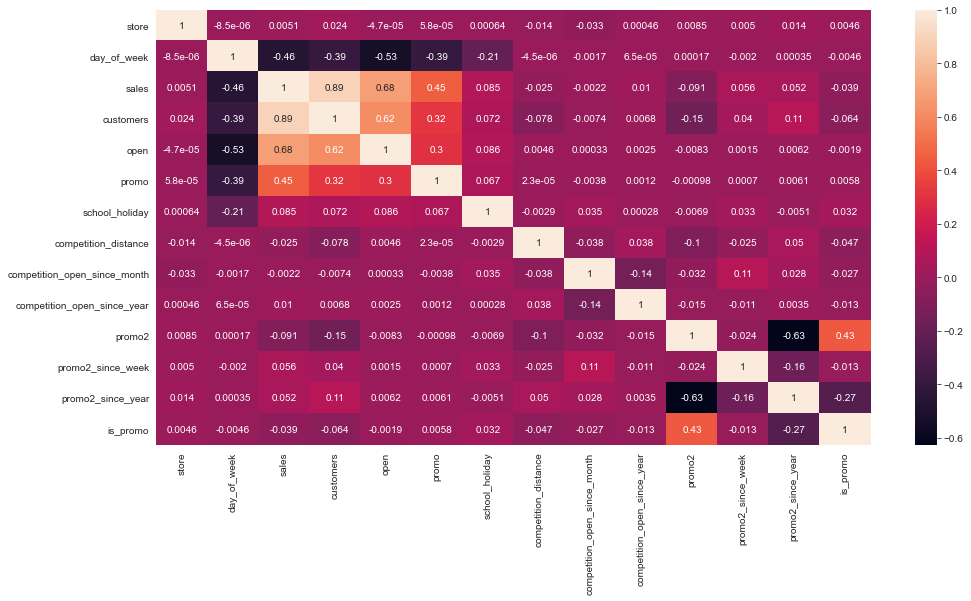

In [80]:
# Correlação entre as variáveis numéricas
correlation = num_attributes.corr(method='pearson')


fig, ax = plt.subplots()

# Tamnho da figura
ax.figure.set_size_inches(16, 8)

# Plotando o mapa de calor
sns.heatmap(correlation, annot=True)

# Exibição do gráfico
plt.show()

Da tabela acima compreendo que a maioria das variáveis numéricas não é dependente uma da outra, pois possuem correlações desprezíveis. As variáveis que possuem alguma dependência com a variável resposta são: 'day_of_week', 'open' e 'promo'. Temos também a variável 'Customers', mas essa variável foi excluída antes por não fazer parte desse projeto.

A partir das correlações mais significativas das variáveis com a variável alvo, essas variáveis são consideradas relevantes para serem utilizadas no modelo de Machine Leaning. Porém, nas seguintes seções, ire utilizar um algoritmo que faz as seleções das melhores variáveis para aplicação no modelo.

### 4.3.2. Atributos Categóricos 

Para calcular a correlação entre atributos categóricos, utilizamos a medida de associação. E uma medida de associação que utilizarei, neste caso, é o  **V de Cramer**. 

Antes de definir **V de Cramer**, preciso estabelecer o que é o coeficiente de contigência quadrático médio que utiliza o próprio valor estatístico de $\chi^{2}$ como uma medida de associação, mas como $\chi^{2}$ depende de $n$, isto implica que a medida aumenta em $n$. Logo, o coeficiente de contingência quadrático médio é dado por


$\varphi^{2} = \frac{\chi^{2}}{n}$.


Portanto, V de Cramer é dada pela equação

$V = \sqrt{\frac{\varphi^{2}}{min(k-1, r-1)}} = \sqrt{\frac{\frac{\chi^{2}}{n}}{min(k-1, r-1)}}$,

onde

$\varphi$ é o coeficiente.

$\chi^{2}$ é derivado do teste Qui-quadrado de Pearson.

$n$ é o número total de observações.

$k$ é o número de colunas. 

$r$ é o número de linhas.


O coeficiente V de Cramer varia entre 0 e 1. Assim, se o valor é de aproximação a 1 tem forte correlação (forte dependência) e a aproximação a 0 tem fraca correlação (forte independência).

No entanto, **O V de Cramer** pode ser um estimador altamente tendencioso da sua contraparte populacional. Logo, tenderá a sobrestimar a força da associação. Por conseguinte, é feita uma **correção da associação** utilizando a equação acima, que é

$ \tilde{V} = \sqrt{\frac {\tilde{\varphi}^{2}}{\min(\tilde{k}-1,\tilde{r}-1)}}$

onde,

$ \tilde{\varphi }^{2}=\max\left(0,\varphi ^{2}-{\frac {(k-1)(r-1)}{n-1}}\right) $

e

$\displaystyle\tilde{k}=k-\frac {(k-1)^{2}}{n-1}$ e $ \displaystyle\tilde {r}=r-{\frac {(r-1)^{2}}{n-1}} $.

In [81]:
# Variáveis Categóricas do dataset
df_cv= df4.select_dtypes(include='object')
df_cv.head()

,state_holiday,store_type,assortment,year_week,before_after
0,regular_day,c,basic,2015-30,after_10_days
1,regular_day,a,basic,2015-30,after_10_days
2,regular_day,a,basic,2015-30,after_10_days
3,regular_day,c,extended,2015-30,after_10_days
4,regular_day,a,basic,2015-30,after_10_days


In [82]:
# Removendo coluna before_after
col = ['before_after']
df4 = df4.drop(col, axis = 1)

In [83]:
# Visualizando variáveis categóricas
df_cv= df4.select_dtypes(include='object')
df_cv.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


Da teoria de V de Cramer vista acima, irei fazer uma função auxiliar que realiza o cálculo de V de Cramer.

In [84]:
# Função V de Cramer
def cramer_v(var_x, var_y):
    
    # Construção da matriz de contigência
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # Soma de todos os valores da matriz
    n = confusion_matrix.sum()
    
    # linhas, colunas
    r, k = confusion_matrix.shape
    
    # Qui-quadrado
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    
    # Viés de correção
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # Retorna V de Cramer
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

Utilizando a função de V de Cramer, temos os seguintes resultados no mapa de calor

In [85]:
#combinations between categorical variables
a1 = cramer_v(df_cv['state_holiday'], df_cv['state_holiday'])
a2 = cramer_v(df_cv['state_holiday'], df_cv['store_type'])
a3 = cramer_v(df_cv['state_holiday'], df_cv['assortment'])

a4 = cramer_v(df_cv['store_type'], df_cv['state_holiday'])
a5 = cramer_v(df_cv['store_type'], df_cv['store_type'])
a6 = cramer_v(df_cv['store_type'], df_cv['assortment'])

a7 = cramer_v(df_cv['assortment'], df_cv['state_holiday'])
a8 = cramer_v(df_cv['assortment'], df_cv['store_type'])
a9 = cramer_v(df_cv['assortment'], df_cv['assortment'])

# dataset of the correlations
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],
             })

#index equal to columns
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


Portanto, podemos traçar as correlações das variáveis categóricas

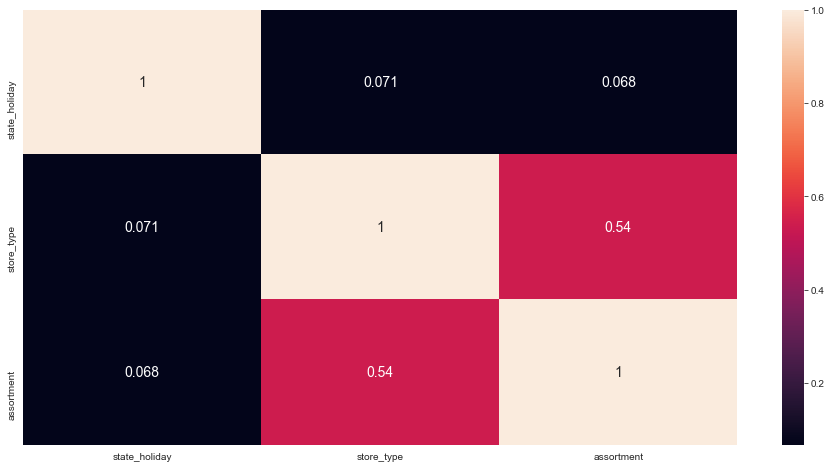

In [86]:
# Utiliza a variável ax para um único eixo
fig, ax = plt.subplots()

# Tamanho da Figura
ax.figure.set_size_inches(16, 8)

# Plotando Mapa de Calor
sns.heatmap(d, annot=True, annot_kws={"fontsize":14})

# Exibição do gráfico
plt.show()

De acordo com o mapa de calor, concluo que a maior correlação ocorre entre *assortment* e *store type*. O resultado de 0,54 é uma correlação média. Isto significa que quanto maior for a loja, maior é o sortido dos seus produtos. Com respeito às correlações das outras variáveis próximas de zero, finalizo que são fracas e independentes.

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

Nesta etapa, farei a preparação de dados, que é a modelagem de dados para o treino do modelo. A razão para isto é que a aprendizagem da maioria dos algoritmos de machine learning é facilitada com dados numéricos na mesma escala.

#### Como preparar os dados ?

Existem basicamente três processos de preparação dos dados que podem ser usado:


* Normalização


* Rescaling


* Transformação


Irei explicar esses processos nas subseções. Antes, vou fazer uma cópia do conjunto de dados.

In [87]:
# Salvando uma cópia do conjunto de dados
df5 = df4.copy()

## 5.1. Normalização

O processo de normalização trabalha para as variáveis que têm uma distribuição normal. Assim, a normalização toma variáveis com estas características e transforma-as em distribuições normais padronizadas, ou seja, distribuições normais com média 0 e desvio padrão 1. A equação abaixo descreve o processo

$Z = \dfrac{x - \mu}{\sigma}$,

onde

$\mu$ = média

$\sigma$ = desvio-padrão.

Neste processo, tenho que ver as distribuições da análise univariada que têm uma distribuição normal.

Ao verificar as distribuições, concluo que nenhuma distribuição é normal. Por conseguinte, não há nada o que fazer. 

## 5.2. Rescaling

O processo de redimensionamento funciona para as variáveis que não têm uma distribuição normal, ou seja, as variáveis têm distribuições não gaussianas. Por conseguinte, os seus intervalos são redimensionados contendo média 0 e desvio padrão 1.

In [88]:
# Selecionando as variáveis numéricas
a = df5.select_dtypes(include = ['int32', 'int64', 'float64'])

In [89]:
# Visualizando conjunto de dados
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


Há dois métodos de rescaling que pode ser utilizado nas variáveis. São eles: **Min-Max-Scaler** and **Robuster-Scaler**

#### Min-Max-Scaler

Basicamente, neste método, vamos pegar na coluna da variável de associação que queremos transformar e e aplicar a equação abaixo

$ X_{new} = \dfrac{X_{i} - \mu}{X_{max} - X_{min}}$,

onde

$X_{new}$ = novo valor da variável

$X_{i}$ = valor da coluna na variável.

$\mu$ = média da variável

$X_{max}$ = valor máximo corresponde á variável

$X_{min}$ = valor mínimo corresponde á variável

A aplicação Min-Max-Scaler não altera a natureza das variáveis, mantendo as distribuições. O que vai mudar é apenas o intervalo. Mas, a aplicação Min-Max-Scaler apresenta um problema que está relacionado com os valores outliers das variáveis, porque considerando estes valores na equação pode trazer os resultados dos dados transformados muito perto de zero da nova escala geradora de um cluster. E isso retira o formato da distribuição.

Portanto, podemos utilizar o método Robuster-Scaler que utiliza quartis em vez do valor máximo e mínimo.


#### Robuster-Scaler

Da mesma forma que o anterior, vamos pegar na coluna da variável de associação que queremos transformar e aplicar a equação abaixo

$ X_{new} = \dfrac{X_{i} - Q_{1}}{Q_{3} - Q_{1}}$

onde

$X_{i}$ = valor da coluna na variável

$Q_{1}$ = primeiro quartil

$Q_{3}$ = terceiro quartil

O Robust-Scaler é um método que pode resolver o problema dos outliers enfrentado em Min-Max-Scale, porque utiliza Q1 e Q3. Logo, para aplicar um dos métodos apresentados, precisamos de analisar o boxplot de cada variável. Assim, se a variável atribuída tiver muitos outliers, utilizamos o Robust-Scaler. Caso contrário, utilizamos o Min-Max-Scaler. 

Portanto, analisarei os boxplots de cada variável escolhida e aplicarei os métodos.

In [90]:
# Métodos de Rescaling
rs = RobustScaler()
mms = MinMaxScaler()

### 5.2.1 Rescaling competition_distance

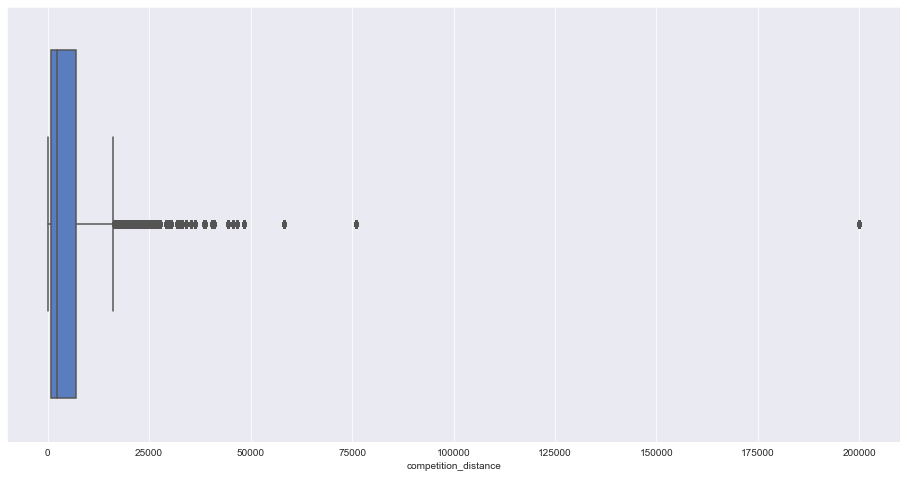

In [91]:
# Plotando boxplot para verificar outliers

fig, ax = plt.subplots()

# Tamanho das figuras
ax.figure.set_size_inches(16,8)

# Plotando gráfico boxplot
ax = sns.boxplot(df5['competition_distance'])

# Exibição do gráfico
plt.show()

Observando o boxplot acima, há uma clara presença de outliers.

In [92]:
# Rescaling competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
df5['competition_distance'].head()

0   -0.170968
1   -0.283871
2    1.903226
3   -0.275806
4    4.448387
Name: competition_distance, dtype: float64

### 5.2.2 Rescaling competition_time_month

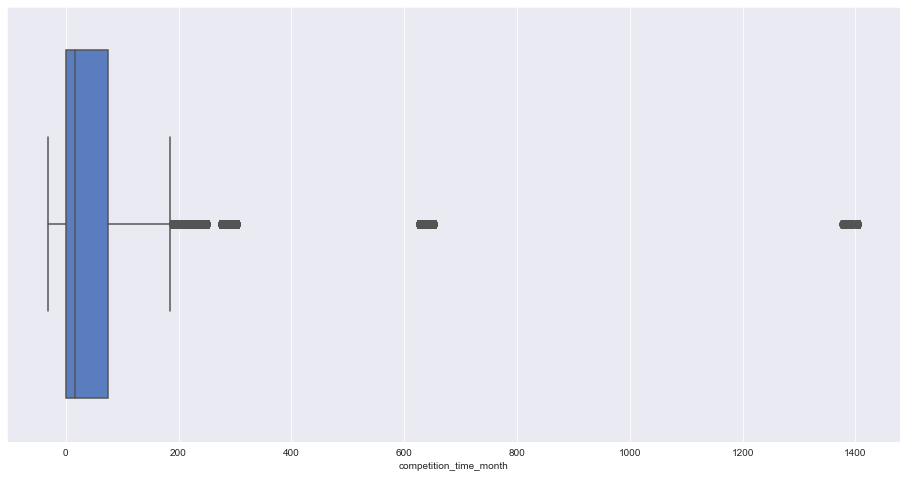

In [93]:
# Plotando boxplot para verificar outliers

fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16,8)

# Plotando gráfico boxplot
ax = sns.boxplot(df5['competition_time_month'])

plt.show()

Observando o boxplot acima, há uma clara presença de outliers.

In [94]:
# Rescaling competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
df5['competition_time_month'].head()

0    0.918919
1    1.054054
2    1.202703
3    0.743243
4   -0.162162
Name: competition_time_month, dtype: float64

### 5.2.3 Rescaling promo_time_week

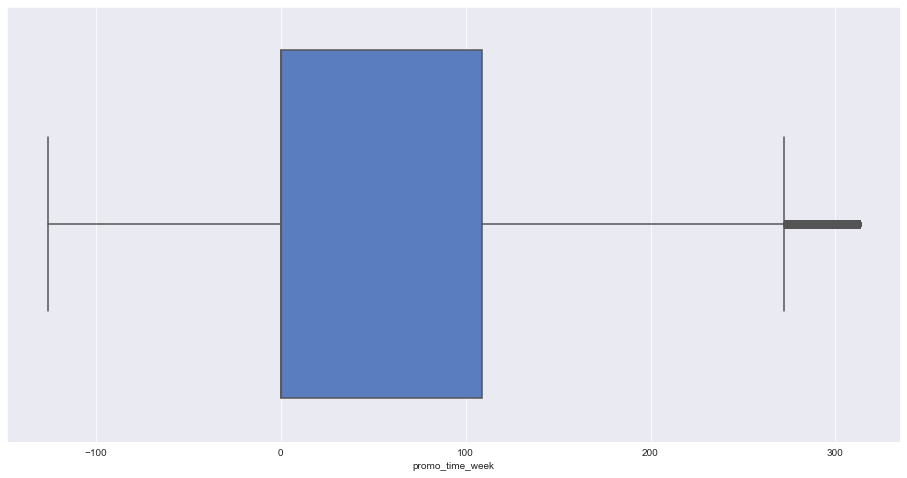

In [95]:
# Plotando boxplot para verificar outliers

fig, ax = plt.subplots()

# Tamanho da Figura
ax.figure.set_size_inches(16,8)

# Plotando boxplot
ax = sns.boxplot(df5['promo_time_week'])

# Exibição do gráfico
plt.show()

Observando os resultados, há uma clara presença de outliers. No entanto, não estão assim tão longe do whisker superior. Por isso, pode-se correr o risco de usar o Escalador Min-Max.

In [96]:
# Rescaling promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
df5['promo_time_week'].head()

0    0.287016
1    0.922551
2    0.801822
3    0.287016
4    0.287016
Name: promo_time_week, dtype: float64

### 5.2.4 Rescaling year

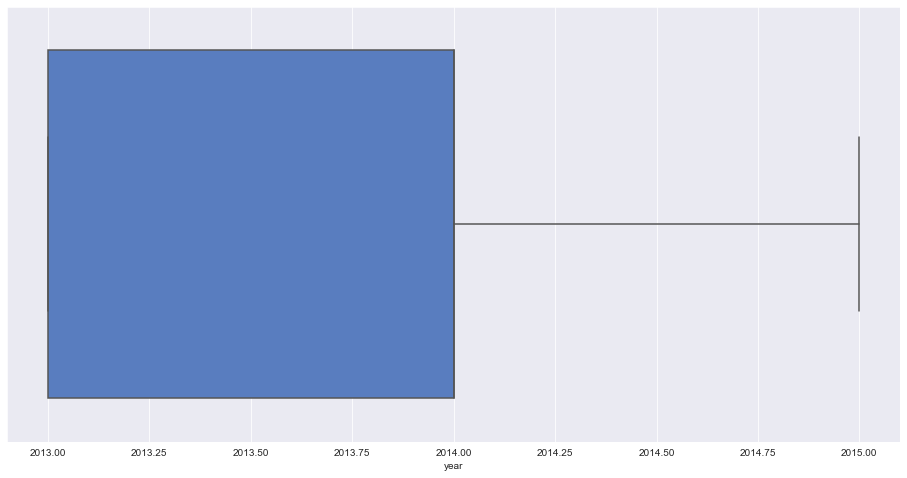

In [97]:
# Plotando boxplot para verificar outliers

fig, ax = plt.subplots()

# Tamanho da Figura
ax.figure.set_size_inches(16,8)

# Plotando boxplot
ax = sns.boxplot(df5['year'])

# Exibindo gráfico
plt.show()

In [98]:
# Rescaling promo_time_week
df5['year'] = mms.fit_transform(df5[['year']].values)
df5['year'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: year, dtype: float64

### 5.2.5. Rossmann's Class Parameters 

In [99]:
#rescaling competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/competition_distance_scaler.pkl', 'wb' ))

#rescaling competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/competition_time_month_scaler.pkl', 'wb' ))

#rescaling promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/promo_time_week_scaler.pkl', 'wb' ))

#rescaling year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/year_scaler.pkl', 'wb' ))

## 5.3. Transformação

No processo de preparação de dados de transformação, vamos verificar três técnicas: **Encoding**, **Transformação da variavel resposta** e **Transformação de natureza**.

### 5.3.1. Encoding

Na técnica Encoding, convertemos a variável categórica em variável numérica mantendo o conteúdo da informação. Logo, utilizarei **One Hot Encoding**, **Label Encoding** e **Ordinal Encoding** para essa conversão.

#### 5.3.1.1. One-hot Encoding

One-hot Encoding é usada para transformar variáveis categóricas representados como números, porém, cuja ordem não é relevante. para evitar que os modelos interpretem esses atributos como sendo númericos, são criadas variáveis binárias, cada uma para um valor possível que o atributo pode assumir. Dessas novas variáveis binárias, a única que terá valor 1 será correspondente à categoria do atributo instância.

 Vou usar esse método na variável 'state_holiday'.

In [100]:
# State holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

In [101]:
# Verificando conjunto de dados
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,-0.170968,-0.283871,1.90323,-0.275806,4.44839
competition_open_since_month,9,11,12,9,4


Observando o dataset acima, a variável 'state_holiday' foi convertida para númerica.

#### 5.3.1.2. Label Encoding

Na técnica de Label Encoding, a cada label é atribuido um número inteiro único baseado na ordem alfabética. Vou utilizar esse método na variável 'store_type'.

In [102]:
# Label Enconder
le = LabelEncoder()

In [103]:
# Store type
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/store_type_scaler.pkl', 'wb' ))

In [104]:
# Verificando conjunto de dados
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


Observando o conjunto de dados acima, a variável 'store_type foi convertida conforme o método.

#### 5.3.1.3. Ordinal Encoding

No método de Ordinal Encoding, os labels numéricos estão sempre entre 1 e o número de classes, em que os labels escolhidos para as categorias não têm qualquer relação. Assim, as categorias que têm algumas ligações ou que estão próximas umas das outras perdem essa informação após o encoding. Os primeiros valores únicos na sua coluna passam a ser 1, o segundo 2, o terceiro 3, e assim por diante.

No caso, aplicarei a técnica à variável 'assortment'.

In [105]:
#assortment - a ordem importa 
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

# mapa de nomes
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [106]:
#checking dataset
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


Observando o conjunto de dados acima, a variável 'assortment' foi transformada conforme o método.

### 5.3.2. Response Variable Transformation

Na transformação da variável resposta, temos que aproximar a distribuição da variável resposta para uma distribuição normal. Isto é necessário porque os algoritmos de machine learning são construídos com base em certas suposições, e uma dessas suposições é que os dados são normalmente distribuídos.

Portanto, para fazer isso, utilizarei o método de transformação logaritmica que aproxima a distribuição em uma normal.

In [107]:
# Aplicando logaritmo
df5['sales'] = np.log1p(df5['sales'])

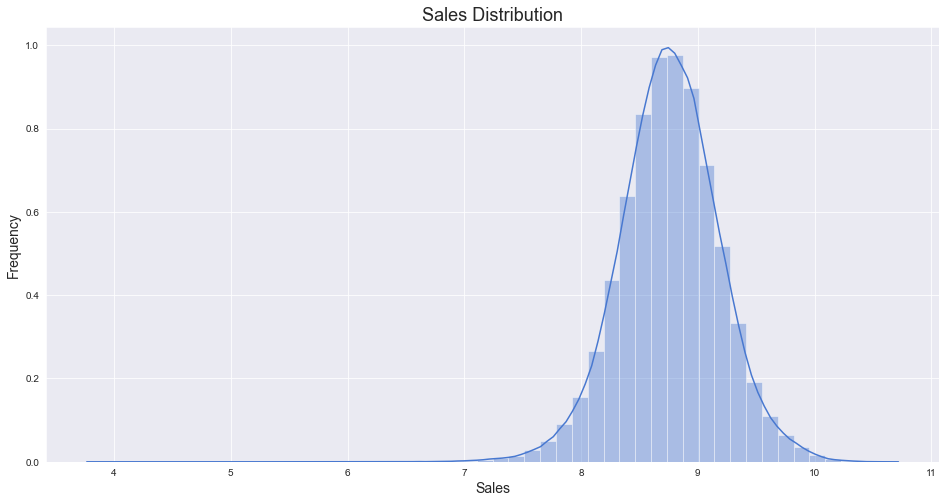

In [108]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16,8)

# Plotando a distribuição
ax = sns.distplot(df5['sales'])

# Títulos e eixos
set_plots_features(ax, 'Sales Distribution','Sales','Frequency')

# Exibindo o gráfico
plt.show()

### 5.3.3.Transformação de Natureza

Na transformação de natureza, temos que trazer a verdadeira natureza dos dados para o dataset. No caso, a variável 'month' é cíclica e tem que ser transformada, pois os meses se repetem a cada ano que se inicia. Mas para isso não enumeramos apenas os meses de 1 a 12 porque perdemos o sentido de ciclo devido às diferentes distâncias.

Por exemplo, tomamos o mês janeiro de 2018, verificamos que há longa distância até dezembro de 2018, mas não necessariamente, dezembro de 2018 está longe do mês de janeiro de 2019. O que acontece é que dezembro de 2018 tem a mesma distância de janeiro de 2019 que março de 2018 tem de abril de 2018. E as mesmas distância mantém um ciclo.


Portanto, utilizarei o círculo trigonométrico colocando os meses como arcos e separando-os a distâncias iguais. Este processo será feito para as variáveis **'day_of_week', 'month', 'day', 'week_of_year'**.

In [109]:
# Variáveis de natureza ciclica

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52)))

In [110]:
# Verificando conjunto de dados
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

Neste módulo 06, farei a feature selection. Isto é importante para facilitar a compreensão dos algoritmos de machine learing. Assim, precisamos utilizar modelos mais simples que envolvam o conjunto de dados com uma série de colunas corretas.

Esse passo verificará quais as variáveis do conjunto de dados que são colineares, ou seja, variáveis que explicam a mesma informação, para as remover porque as variáveis deste tipo não são necessárias para uso. Há alguns tipos de feature selection como: Métodos de Filtragem, Métodos Incorporados, Métodos de Embalagem e Boruta.

O método que utilizarei neste projeto é o  **Boruta**. Assim, farei uma cópia do conjunto de dados para salvar o que já feito.

In [111]:
# Copiando o dataset
df6 = df5.copy()

In [112]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [113]:
# Removendo as variáveis do dataset que estão em formato categórico.
cols= ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols, axis = 1)

In [114]:
# Visualizando o dataset
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [115]:
# Dimensão do dataset
df6.shape

(844338, 29)

## 6.1. Separando os Dados em Treino e Teste

Antes de fazer a feature selection das variáveis, irei já separar os dados de treino e teste que será usado na aplicação dos modelos. Como o objetivo do projeto é fazer uma previsão de vendas das próximas seis semanas, o conjunto de dados de testes terá os dados das vendas feitas nas últimas seis semanas e o conjunto de treino compreenderá com o restante. 

In [116]:
# Obtém as primeiras datas de vendas
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [117]:
# Obtém as últimas datas de venda para cada loja
df6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [118]:
# Obtém a data antes das últimas seis semanas de vendas para cada loja. 
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [119]:
# Criando dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# criando dataset de teste
X_test = df6[df6['date'] >= '2015-06-19' ]
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min() ) )

print('Training Max Date: {}'.format(X_train['date'].max() ) )

print('Test Min Date: {}'.format(X_test['date'].min() ) )

print('Test Max Date: {}'.format(X_test['date'].max() ) )



Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Feature Selector com Boruta

Com o conjuntos de treino e teste já definidos, irei utilizar o algoritmo Boruta para fazer a selação de features.

In [125]:
# Define dados de treino e teste para o Boruta - pq não pode passar um dataframe tem que passar um vetor de numeros
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
Y_train_n = Y_train.values.ravel()

# Define RamdomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Melhores Features Selecionadas pelo Boruta

In [121]:
# Lista de features pelo Boruta
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Lista de features não selecionadas pelo Boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs, cols_selected_boruta))

# Analisar as melhores features com as hipoteses relevantes

In [128]:
print(cols_selected_boruta)

['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos']


Com a seleção de features já realizadas pelo Boruta, o próximo passo que farei é analisar as melhores features com as hipóteses relevantes que foram definidas no momento da Análise Exploratória de Dados.

## 6.3. Seleção de Features Manualmente

In [122]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
   ]

In [123]:
#inserindo variáveis
feat_to_add = ['date', 'sales']

#final selected features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [124]:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. PASSO 07 - MODELOS DE MACHINE LEARNING

Neste módulo, aplicarei os modelos de Machine Learning em que a motivação para a utilização destes algoritmos é aprender o comportamento de vendas com as variáveis disponíveis e depois generalizá-lo para o futuro, já que este projeto é de regressão.

Existem vários tipos de algoritmos de Machine Learning. Para este projeto, utilizarei algoritmos de tarefa supervisionada, nos quais as técnicas de regressão são aplicadas como:

* Average Model


* Linear Regression Model


* Lasso Regression


* Random Forest Regressor


* XGBoost Regressor


Porém, antes de tudo, vou separar os dados baseando-se nas features escolhidas no passo 6.

### 7.0.1. Separando os dados

In [125]:
# Selecionando as colunas escolhidas pelo Boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Dados de preparação para Time Series
x_training = X_train[cols_selected_boruta_full]

In [126]:
# Criando conjunto de dados para teste
aux1 = x_test.copy()

In [127]:
aux1

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47940,1111,1,0,1,-0.069355,6,2014,1,31,2013,-0.054054,0.510251,-0.974928,-0.222521,1.224647e-16,-1.000000,-0.743145,-0.669131,0.120537,-0.992709
47941,1112,1,2,3,-0.072581,4,2006,0,25,2015,1.297297,0.287016,-0.974928,-0.222521,1.224647e-16,-1.000000,-0.743145,-0.669131,0.120537,-0.992709
47942,1113,1,0,3,1.117742,6,2015,0,25,2015,-0.216216,0.287016,-0.974928,-0.222521,1.224647e-16,-1.000000,-0.743145,-0.669131,0.120537,-0.992709
47943,1114,1,0,3,-0.235484,6,2015,0,25,2015,-0.216216,0.287016,-0.974928,-0.222521,1.224647e-16,-1.000000,-0.743145,-0.669131,0.120537,-0.992709


## 7.1. Average Model

In [128]:
aux1['sales'] = Y_test.copy()

In [129]:
# predição
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(Y_test) , np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [130]:
# Modelo
lr = LinearRegression().fit(x_train, Y_train)

# Predição
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [131]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [132]:
# Modelo
lrr = Lasso(alpha= 0.01).fit(x_train, Y_train)

# Predição
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [133]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [134]:
# Modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# Predição
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [135]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv = pickle.load(open('/Users/diasn/DS/DataScienceEmProducao/rf_result_cv.pkl', 'rb'))

In [136]:
rf_result_cv

,MAE CV,MAPE CV,RMSE CV
0,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## 7.5. XGBoost Regressor

In [137]:
# Modelo
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror', n_estimators=100,
                             eta = 0.01, max_depth = 10, subsample = 0.7,colsample_bytee = 0.9).fit( x_train, Y_train)

# Predição
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112292,0.122609,1250.952634


### 7.5.1. XGBoost Regressor - Cross Validation

In [138]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_result_cv = pickle.load(open('/Users/diasn/DS/DataScienceEmProducao/xgb_result_cv.pkl', 'rb'))

In [139]:
xgb_result_cv

,MAE CV,MAPE CV,RMSE CV
0,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [140]:
modelling_result  = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,843.112292,0.122609,1250.952634
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [141]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

O módulo de Hyperparameter Fine Tuning serve para encontrar o conjunto de parâmetros que maximizam o modelo de Machine Learning.

Existem três estratégias de ajuste fino de hiperparâmetros:

- Random Search - define valores para cada um dos hiperparâmetros aleatoriamente.


- Grid Search - define todas as combinações possíveis de valores que os hiperparâmetros podem assumir.


- Bayesian Search - Define os valores para os hiperparâmetros seguindo a Teoria de Bayes.

Para o projeto, usarei a **Random Search** porque é rápida de executar e fácil de implementar.

## 8.1. Random Search

In [142]:
param = { 
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 10

In [143]:
# conforme os parametros escolhidos, o random search demora para fazer as escolhas

#final_result = pd.DataFrame()

#for i in range( MAX_EVAL):
    #Choose values for parameters ramdomly
    #hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    #print(hp)
    #model
   # model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror', 
                                 # n_estimators=hp['n_estimators'], 
                                 # eta = hp['eta'], 
                                 # max_depth = hp['max_depth'], 
                                 # subsample = hp['subsample'], 
                                 # colsample_bytee = hp['colsample_bytree'],
                                 # min_child_weight = hp['min_child_weight'])

    #performance
    #result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
   # final_result = pd.concat([final_result, result])

#final_result

#Selecionou os parametros da linha 2 para colocar no modelo final depois que o Random Search concedeu parametros randomizados.

In [144]:
cv = {'Model Name': ['XGBoost Regressor', 'XGBoost Regressor', 'XGBoost Regressor', 'XGBoost Regressor', 'XGBoost Regressor'],
      'MAE CV': [1112.91 , 1104.41, 896.48, 890.79, 1113.26 ],
      'STD MAE CV':[138.13, 133.24, 152.07, 149.22, 130.60],
      'MAPE CV': [0.16, 0.15, 0.13, 0.13, 0.16],
      'STD MAPE CV': [0.01, 0.01, 0.02, 0.02, 0.01],
      'RMSE': [1586.60, 1568.59, 1270.46, 1272.94, 1583.53], 
      'STD RMSE CV': [179.02, 171.77, 214.55, 214.22, 174.07]}

fr = pd.DataFrame(cv)
fr

,Model Name,MAE CV,STD MAE CV,MAPE CV,STD MAPE CV,RMSE,STD RMSE CV
0,XGBoost Regressor,1112.91,138.13,0.16,0.01,1586.60,179.02
1,XGBoost Regressor,1104.41,133.24,0.15,0.01,1568.59,171.77
2,XGBoost Regressor,896.48,152.07,0.13,0.02,1270.46,214.55
3,XGBoost Regressor,890.79,149.22,0.13,0.02,1272.94,214.22
4,XGBoost Regressor,1113.26,130.60,0.16,0.01,1583.53,174.07


## 8.2. Modelo Final

Os parâmetros da variável **param_tuned** foram escolhidos de acordo com os resultados na linha 2 da tabela acima. As métricas foram estabelecidas pela Random Search.

**NOTA**: Como a pesquisa aleatória leva tempo para escolher os parâmetros, ela não foi executada. Os parâmetros foram obtidos quando o algoritmo foi executado pela primeira vez.

In [145]:
param_tuned = { 
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5, 
    'subsample': 0.7,
    'colsample_bytree': 0.7 ,
    'min_child_weight': 3 
        }

In [146]:
# Modelo
model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror', 
                                   n_estimators=param_tuned['n_estimators'],
                                   eta = param_tuned['eta'], 
                                   max_depth = param_tuned['max_depth'], 
                                   subsample = param_tuned['subsample'], 
                                   colsample_bytee = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, Y_train)
# Predição
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974996,0.097529,957.774225


## 8.3. Salvando o Modelo

Visto que maximizar o modelo final leva tempo para ser executado, executamos o resultado do modelo uma vez e salvamos usando o pacote de pickle.

In [147]:
model_xgb_tuned = pickle.load(open('/Users/diasn/projetos/DataScienceEmProducao/pickle/model_rossmann.pkl', 'rb'))

In [148]:
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [149]:
yhat_xgb_tuned

array([ 8.610663,  8.553743,  9.168833, ...,  8.846759, 10.072041,
        9.131205], dtype=float32)

In [150]:
xgb_result_tuned = pickle.load(open('/Users/diasn/projetos/DataScienceEmProducao/pickle/xgb_result_tuned.pkl', 'rb'))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974996,0.097529,957.774225


# 9.0. PASSO 09 - INTERPRETAÇÃO E TRADUÇÃO DO ERRO

No módulo de Interpretação e Tradução do Erro, irei analisar o Desempenho do Negócio e o Desempenho Total do Modelo. Isso é importante para entender o desempenho do modelo e dizer ao CEO quanto dinheiro esse modelo trará para a empresa.

As métricas MAE e MAPE são utilizadas para a interpretação da **linguagem empresarial**. E o RMSE para a interpretação do **modelo de desempenho**.

<h3> Características de cada Métrica de Erro </h3>
    
    
* MAE
    
   - Atribui peso igual a todos os erros.
   - Robusto na presença de Outliers.
   - Fácil entendimento pela equipe de negócios.
   
* MAPE

   - Mostra a que distância a previsão está do valor real, em média, como uma porcentagem.
   - Muito utilizado para relatar resultados.
   - Não pode ser usado se a variável de resposta contém zero. Se tiver que prever zero, terá que usar outras métricas.
   
* RMSE

   - Dá muito peso a erros grandes.
   - Sensível na presença de outliers.
   - Ideal para medir o desempenho do modelo de aprendizado de máquina.
   

In [151]:
# 
df9 = X_test[cols_selected_boruta_full]

Como aplicamos a transformação de variáveis, preciso transformá-las de volta à escala original.

In [152]:
# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Performance de Negócio

In [153]:
# Soma das Predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE e MAPE - Reportando valores de negócios
#MAE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], 
                                                              x['predictions'])).reset_index().rename(columns = {0:'MAE'})
#MAPE
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], 
                                                              x['predictions'])).reset_index().rename(columns = {0:'MAPE'})
# Juntando - store, MAE, MAPE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')

# Juntando - store, predictions, MAE, MAPE
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Criando cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordenando colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [154]:
# Visualizando Dados
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162606.312500,162299.567548,162913.057452,306.744952,0.070183
1,2,170870.984375,170449.574879,171292.393871,421.409496,0.087380
2,3,262130.968750,261543.968466,262717.969034,587.000284,0.084673
3,4,345748.687500,344893.119075,346604.255925,855.568425,0.081451
4,5,171662.046875,171299.253712,172024.840038,362.793163,0.079369


Como podemos ver nos resultados, temos as métricas MAE e MAPE presentes. **Mas o que esses números significam para a performance de negócios ?**

De forma bem simples, vamos pegar, como exemplo, a store 02, em que o MAE é de 421.41 reais e o MAPE é de aproximadamente 0.09 (9%). Isso significa que o ASM é a porcentagem do MAE. Portanto, podemos concluir que a loja 02 terá uma previsão de vendas de 170.870,98 reais e que o erro médio sobre as vendas diárias é de 421.41 reais para mais ou menos, e isso representa 9%.

A título de interpretação, para a equipe empresarial este erro é relativamente baixo em relação ao número de vendas esperado. Este método ajuda a equipe de negócios a tomar uma decisão.

In [155]:
# Visualizando dados por ordem crescente - MAPE
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.078125,100714.973723,107351.182527,3318.104402,0.565828
908,909,238233.875000,230573.337190,245894.412810,7660.537810,0.520433
875,876,203030.156250,199110.952456,206949.360044,3919.203794,0.305099
721,722,353005.781250,351013.625224,354997.937276,1992.156026,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


Conforme observado nos resultados acima, preciso reportar ao negócio que existem lojas que são mais difíceis de fazer as previsões. Algumas estratégias que podem resolver esse desafio na próxima iteração do CRISP podem ser dar uma olhada nas variáveis, tentar outros métodos, tentar outras técnicas.

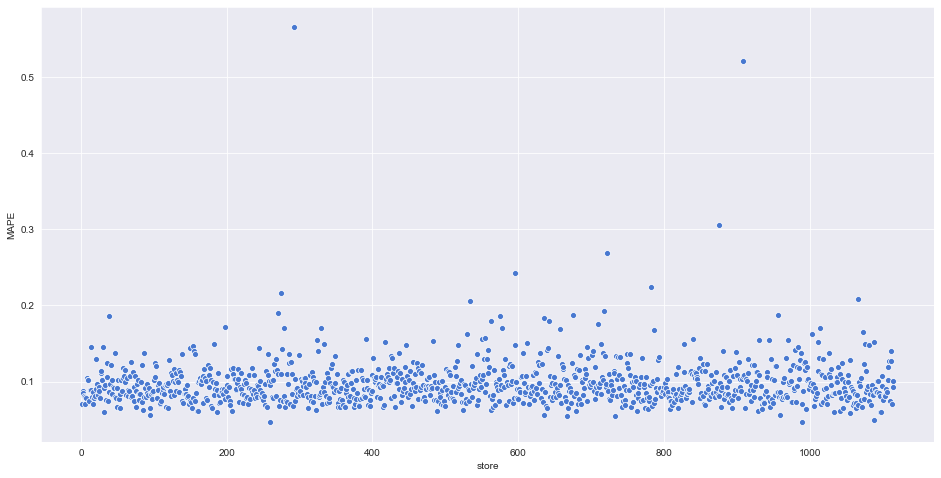

In [156]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16,8)

# Plotando gráfico de dispersão
ax = sns.scatterplot(x ='store', y='MAPE', data = df92 )

# Exibindo gráficos
plt.show()

Observando os resultados acima, existem lojas que possuem valores de MAPE superiores. Então, essas são as lojas que apresentam previsões desafiadoras.

## 9.2. Performance Total

Aqui, mostrarei a performance total do modelo com as predições exibindo o melhor e o pior cenário.

In [157]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), 
                                                               axis = 0).reset_index().rename(columns={'index':'Scenario',
                                                                                                       0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)

df93

,Scenario,Values
0,predictions,"R$285,860,497.74"
1,worst_scenario,"R$285,115,015.68"
2,best_scenario,"R$286,605,979.81"


Acima, podemos observar  que a predição total será de 285.860.497,74 reais. O melhor cenário é de  286.605.979,81 reais e o pior cenário de 285.115.015,68 reais.

## 9.3. Performance do Modelo Machine Learning 

In [158]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

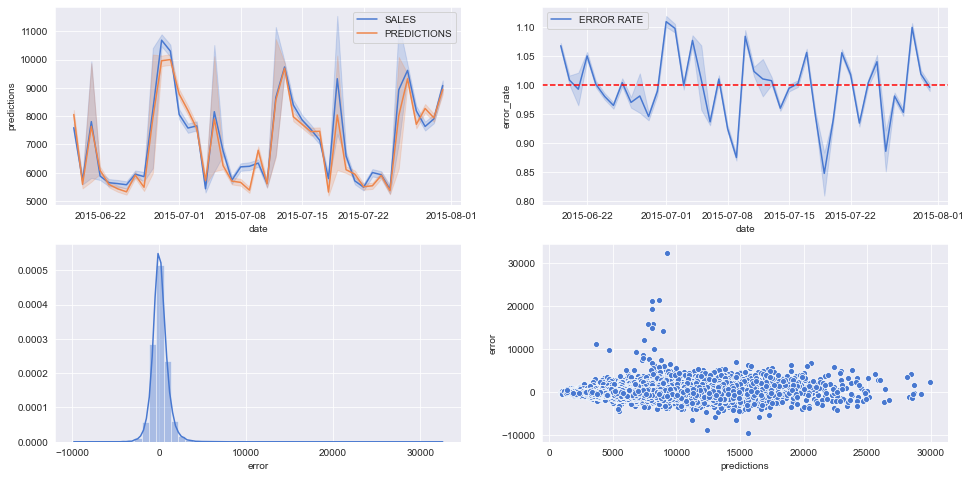

In [159]:
fig, ax = plt.subplots()

# Tamanho da figura
ax.figure.set_size_inches(16, 8)

# Plotando os dados
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')


# Plotando os dados
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9, label='ERROR RATE')
plt.axhline(1, linestyle='--', color='r')


# Plotando gráficos para Análise residual
# Plotando os dados
plt.subplot(2, 2, 3)
sns.distplot(df9['error'])


# Plotando os dados
plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])


# Exibindo os gráficos
plt.show()

Observando os resultados, temos que:

- Os gráficos de primeira e segunda linha estão muito próximo do valor real de vendas. Por outro lado, a taxa de erro tem alguma variação.


-  O histograma, a distribuição do erro, segue quase uma distribuição normal.


- Observando o gráfico de dispersão dos erros, os pontos parecem bem encaixados em um tubo horizontal, o que significa que há algumas variações no erro. Se os pontos formaram qualquer outra forma (por exemplo, cone de abertura / fechamento ou arco), isso significaria que os erros seguem uma tendência e precisaríamos revisar nosso modelo.

# 10. PASSO - DEPLOY DO MODELO EM PRODUÇÃO

Neste último módulo, colocarei o modelo em produção. A motivação para esta etapa é tornar as previsões do modelo acessíveis a qualquer consumidor. Portanto, irei criar uma arquitetura de produção no https://id.heroku.com/login


<h3> Lista de Tarefas </h3>


- Criar uma classe com a limpeza, transformação e codificação. (Rossmann.py)


- Criar uma API (Handler.py)


- Criar um script para testar a API

## 10.1. Rossmann Class

In [160]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path ='C:/Users/diasn/projetos/DataScienceEmProducao/'
        self.competition_distance_scaler    = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
        
        
        
    def data_cleaning(self, df1):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'] 
                

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new


        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA - Do away with empty cells
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) 
                                                    else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                   else x['competition_open_since_year'], axis = 1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                             else x['promo2_since_week'], axis = 1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                             else x['promo2_since_year'], axis = 1)

        #promo_inteval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                                     else 1 if x['month_map'] in x['promo_interval'].split(',') 
                                                                     else 0, axis = 1)

        ## 1.6. Change Types
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
    
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
    
        return df1

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                month = x['competition_open_since_month'], day= 1), axis = 1)

        #competition time month
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        #promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') 
                                                      - datetime.timedelta(days = 7) )

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                      if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        # 3.0. STEP 03 - VARIABLE FILTERING
        
        ## 3.1. Row Filtering 
        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Column Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2

    #select the numerical variables
    #a = df5.select_dtypes(include = ['int32', 'int64', 'float64'])    
    
    def data_preparation(self, df5):

        ## 5.2. Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #rescaling promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #rescaling promo_time_week
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        #state holiday - One Hot Enconding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        #store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment - Ordinal Enconding 
        assortment_dict = {'basic': 1,'extra': 2,'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

    
        ### 5.3.3. Nature Transformation
        #variables with cyclical nature

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
            'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
            'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
            'week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json( orient = 'records', date_format = 'iso')

## 10.2. API Handler

In [173]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('C:/Users/diasn/projetos/DataScienceEmProducao/pickle/model_rossmann.pkl', 'rb'))

#iniatialize API
app = Flask( __name__ )

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: #multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        #Instantiate Rossmann Class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction 
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('192.168.0.18')

## 10.3. API Tester

In [162]:
import json
import requests

In [163]:
# Carregando conjunto de dados de teste
df10 = pd.read_csv('/Users/diasn/projetos/DataScienceEmProducao/data/test.csv')

In [164]:
# Juntando conjunto de dados de teste + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# Escolhendo stores para predição
df_test = df_test[df_test['Store'].isin([20, 12, 22])]

# Removendo lojas de dias fechados
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [165]:
#  Convertendo DataFrame para Json - lista
data = json.dumps(df_test.to_dict(orient = 'records'))

In [166]:
# Chamando API
#url = 'http://192.168.0.18:5000/rossmann/predict'
url = 'https://rossm-nn.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'} 
data = data

r = requests.post(url, data=data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [167]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys() )

In [168]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'],
                                                                           d2.loc[i, 'prediction']))

Store number 12 will sell R$268,636.28 in the next 6 weeks
Store number 20 will sell R$293,525.62 in the next 6 weeks
Store number 22 will sell R$140,049.36 in the next 6 weeks
